## Introduction
L'objectif de ce projet est de développer un modèle de prédiction du risque d'insufisance cardique au sein de la population des Schtroumpfs à partir d'un ensemble de données cliniques et d'images médicales. Les habitudes de vie des Schtroumpfs ayant évolué au fil du temps, le médecin du village fait aujourd'hui face à une augmentation  importante des cas à risque et ne parvient  plus à évaluer chaque patient manuellement. L'apprentissage automatique constitue ainsi une solution permettant d'automatiser et d'ameliorer l'évaluation individuelle  du risque. Le projet se structure en quatre parties : construction d'un premier modèle linéaire à partir des données tabulaires; comparaison et sélection de modèles non linéaire plus expressifs; intégration d'informations issues d'images cardiaque via un réseau convolutionnel; et une analyse approfondie des facteurs expliquant l'augmentation du risque au sein de la société schtroumpfe.
L'objectif final est de sélectionner le meilleur modèle, d'analyser les déterminants du risque et de produire les prédictions finales demandées pour les données non étiquetées.

# Import Librayries

---

In [44]:
import pandas as pd
import os
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, mutual_info_regression, VarianceThreshold, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge, LinearRegression, RidgeCV, Lasso
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy import stats
import time, sys
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor



---
#### 1.1 LECTURE DES DONNÉES - Projet ELEC2870 (Partie 1)
---

In [3]:
# Step 1: Define the base path 

base_path = Path(r"C:\Users\edoun\Documents\Master 2\master_2026\LELEC2870\True_project\data\data\data_labeled")

In [4]:
# Step 2: Create the full paths to the files
# ----------------------------------------------------------
files = {
    "X_train": base_path / "X_train.csv",
    "y_train": base_path / "y_train.csv",
    "X_test": base_path / "X_test.csv",
    "y_test": base_path / "y_test.csv",
    "X_unlabeled": base_path / "X.csv",  # unlabelled data
}

In [5]:
# Step 3: Secure playback function
# ----------------------------------------------------------
def safe_read_csv(path, header="infer"):
    """
    @pre: Secure reading of a CSV file with error handling.
        header='infer' : normal reading
        header=None    : for files without headers
    """
    try:
        df = pd.read_csv(path, header=header)
        print(f" File loaded : {path.name} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
        return df
    except FileNotFoundError:
        print(f"  File not found : {path}")
    except Exception as e:
        print(f" Reading error {path.name}: {e}")
    return None

In [6]:
# Étape 4 : Upload all files
# ----------------------------------------------------------
X_train = safe_read_csv(files["X_train"])
X_test = safe_read_csv(files["X_test"])

#----------The y_* files do not have headers, so we specify header=None.---------------------

y_train = safe_read_csv(files["y_train"], header=None)
y_test = safe_read_csv(files["y_test"], header=None)
X_unlabeled = safe_read_csv(files["X_unlabeled"])

 File loaded : X_train.csv (1000 lignes, 14 colonnes)
 File loaded : X_test.csv (500 lignes, 14 colonnes)
 File loaded : y_train.csv (1000 lignes, 1 colonnes)
 File loaded : y_test.csv (500 lignes, 1 colonnes)
 File loaded : X.csv (500 lignes, 14 colonnes)


In [7]:
X_train.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,84,115.72,2.33,79.05,14.36,7.19,4.32,food production,High,High,Very high,37.82,123.06,heart_1466.png
1,137,110.72,2.25,125.24,16.53,7.44,4.29,services,Moderate,High,Very low,47.06,111.54,heart_128.png
2,105,102.65,2.74,123.59,10.91,7.42,4.06,food production,Very low,Moderate,High,25.79,100.03,heart_710.png
3,86,116.28,2.37,136.83,15.69,7.35,4.63,food production,Low,Very high,Low,22.36,85.09,heart_295.png
4,180,124.92,2.35,137.19,14.55,8.02,5.51,manufacturing,High,Very high,Moderate,16.58,116.05,heart_867.png


In [8]:
# Step 5: Rename the target column for consistency
# ----------------------------------------------------------
if y_train is not None and y_train.shape[1] == 1:
    y_train.columns = ["risk"]
if y_test is not None and y_test.shape[1] == 1:
    y_test.columns = ["risk"]

In [9]:
# ----------------------------------------------------------
# Step 6: Quick check of dimensions
# ----------------------------------------------------------
print("\n=== Dimensions ===")
print(f"X_train : {X_train.shape}")
print(f"y_train : {y_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"y_test  : {y_test.shape}")
print(f"X_unlabeled : {X_unlabeled.shape}")


=== Dimensions ===
X_train : (1000, 14)
y_train : (1000, 1)
X_test  : (500, 14)
y_test  : (500, 1)
X_unlabeled : (500, 14)


In [10]:
# Step 7: Preview of the first lines
# ----------------------------------------------------------
print("\nAperçu de X_train :")
display(X_train.head())

print("\nAperçu de y_train :")
display(y_train.head())



Aperçu de X_train :


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,84,115.72,2.33,79.05,14.36,7.19,4.32,food production,High,High,Very high,37.82,123.06,heart_1466.png
1,137,110.72,2.25,125.24,16.53,7.44,4.29,services,Moderate,High,Very low,47.06,111.54,heart_128.png
2,105,102.65,2.74,123.59,10.91,7.42,4.06,food production,Very low,Moderate,High,25.79,100.03,heart_710.png
3,86,116.28,2.37,136.83,15.69,7.35,4.63,food production,Low,Very high,Low,22.36,85.09,heart_295.png
4,180,124.92,2.35,137.19,14.55,8.02,5.51,manufacturing,High,Very high,Moderate,16.58,116.05,heart_867.png



Aperçu de y_train :


,risk
0,0.06
1,0.07
2,0.09
3,0.01
4,0.26


---
#### 1.2 VERIFICATION DES TYPES ET NETTOYAGE DES COLONNES
---

In [11]:

# ----------------------------------1️. Data type verification----------------------------
print("=== Types de variables dans X_train ===")
print(X_train.dtypes)
print("\nNombre de variables :", X_train.shape[1])

# --------------------------2️.  Overview of the first lines ----------------------------------
print("\nAperçu des données :")
display(X_train.head())

# ------------------------3️. Checking for missing values -------------------------------------
print("\n=== Percentage of missing values ===")
missing_perc = (X_train.isna().mean() * 100).round(2)
print(missing_perc[missing_perc > 0] if (missing_perc > 0).any() else "No missing values detected ")

# --- 4️ Identifying unnecessary columns ---
maybe_image_cols = [col for col in X_train.columns if "img" in col.lower() or "file" in col.lower()]
if maybe_image_cols:
    print(f"\n Colonne(s) non pertinente(s) détectée(s) : {maybe_image_cols}")
    print(" These columns will be excluded from the tabular model..")
else:
    print("\n  No irrelevant columns detected.")

# ----------------------5️. List of categorical and numerical columns ---------------------------
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("\nNumeric variables :", num_cols)
print("Categorical variables :", cat_cols)


=== Types de variables dans X_train ===
age                    int64
blood pressure       float64
calcium              float64
cholesterol          float64
hemoglobin           float64
height               float64
potassium            float64
profession            object
sarsaparilla          object
smurfberry liquor     object
smurfin donuts        object
vitamin D            float64
weight               float64
img_filename          object
dtype: object

Nombre de variables : 14

Aperçu des données :


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,84,115.72,2.33,79.05,14.36,7.19,4.32,food production,High,High,Very high,37.82,123.06,heart_1466.png
1,137,110.72,2.25,125.24,16.53,7.44,4.29,services,Moderate,High,Very low,47.06,111.54,heart_128.png
2,105,102.65,2.74,123.59,10.91,7.42,4.06,food production,Very low,Moderate,High,25.79,100.03,heart_710.png
3,86,116.28,2.37,136.83,15.69,7.35,4.63,food production,Low,Very high,Low,22.36,85.09,heart_295.png
4,180,124.92,2.35,137.19,14.55,8.02,5.51,manufacturing,High,Very high,Moderate,16.58,116.05,heart_867.png



=== Percentage of missing values ===
No missing values detected 

 Colonne(s) non pertinente(s) détectée(s) : ['img_filename']
 These columns will be excluded from the tabular model..

Numeric variables : ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight']
Categorical variables : ['profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'img_filename']


#### SUPPRESSION DES COLONNES NON PERTINENTES

In [12]:
cols_to_drop = ['img_filename']

# Removal of irrelevant columns in all data sets
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')
X_unlabeled = X_unlabeled.drop(columns=cols_to_drop, errors='ignore')

print("Deleted columns :", cols_to_drop)
print("Dimensions after shrinkage :")
print(f"X_train : {X_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"X_unlabeled : {X_unlabeled.shape}")



Deleted columns : ['img_filename']
Dimensions after shrinkage :
X_train : (1000, 13)
X_test  : (500, 13)
X_unlabeled : (500, 13)


---
### 2. Exploration des données (EDA)
---
---

#### 2.1. Statistiques descriptives

In [13]:
def describe_dataset(name, df):
    """
    @ post: Displays a complete description of the dataset:
        - the shape (dimension)
        - Type of column
        - Missing values
        -  first five rows
        - descriptive statistics (numerical and categorical)
    """
    print(f"\n{'='*80}")
    print(f"{name} — Aperçu général")
    print(f"{'='*80}")
    
    if df is None:
        print(" Dataset not found.\n")
        return
    
    #---------------------Dimensions-------------------------------------------
    print(f"Number of rows : {df.shape[0]}")
    print(f"Number of columns : {df.shape[1]}")
    if hasattr(df, "columns"):
        print(f"Names of columns : {list(df.columns)}\n")
    
    #-----------------------Types of dataset--------------------------------------------
    print("Types of  column :")
    try:
        print(df.dtypes)
    except:
        print("No column type detected.\n")
    
    #-------------------------------Missing values----------------------------------------------
    print("\nMissing values :")
    try:
        missing = df.isna().sum()
        print(missing[missing > 0] if missing.sum() > 0 else "No missing value detected ")
    except:
        print("Unable to evaluate missing values (non-DataFrame object).")
    
    # Preview of the first 5 lines
    print("\n First five rows :")
    try:
        display(df.head())
    except:
        print(df[:5])
    
    #------------------------------summary numerical---------------------------------------
    print("\nStatistical summary (numerical variables):")
    try:
        num_desc = df.describe(include=[np.number])
        if not num_desc.empty:
            display(num_desc.T)
        else:
            print("No numerical variables detected.")
    except:
        print(" No digital summary available (probably a Series).")
    
    #----------------------summary categorical-------------------------------------------------
    print("\nStatistical summary (categorical variables) :")
    try:
        cat_desc = df.describe(include=['object'])
        if not cat_desc.empty:
            display(cat_desc.T)
        else:
            print("No categorical variables detected..")
    except:
        print("No categorical variables detected.")
    
    print("\n")

# ==========================================================
#  CALLING THE FUNCTION FOR EACH DATASET
# ==========================================================
describe_dataset("X_train", X_train)
describe_dataset("y_train", y_train)
describe_dataset("X_test", X_test)
describe_dataset("y_test", y_test)
describe_dataset("X_unlabeled", X_unlabeled)



X_train — Aperçu général
Number of rows : 1000
Number of columns : 13
Names of columns : ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight']

Types of  column :
age                    int64
blood pressure       float64
calcium              float64
cholesterol          float64
hemoglobin           float64
height               float64
potassium            float64
profession            object
sarsaparilla          object
smurfberry liquor     object
smurfin donuts        object
vitamin D            float64
weight               float64
dtype: object

Missing values :
No missing value detected 

 First five rows :


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight
0,84,115.72,2.33,79.05,14.36,7.19,4.32,food production,High,High,Very high,37.82,123.06
1,137,110.72,2.25,125.24,16.53,7.44,4.29,services,Moderate,High,Very low,47.06,111.54
2,105,102.65,2.74,123.59,10.91,7.42,4.06,food production,Very low,Moderate,High,25.79,100.03
3,86,116.28,2.37,136.83,15.69,7.35,4.63,food production,Low,Very high,Low,22.36,85.09
4,180,124.92,2.35,137.19,14.55,8.02,5.51,manufacturing,High,Very high,Moderate,16.58,116.05



Statistical summary (numerical variables):


,count,mean,std,min,25%,50%,75%,max
age,1000.0,117.61100,30.169585,20.00,98.0000,118.000,138.0000,180.00
blood pressure,1000.0,108.40230,11.035291,84.93,100.7650,106.085,114.0175,154.54
calcium,1000.0,2.44558,0.205762,1.74,2.3100,2.445,2.5900,3.10
cholesterol,1000.0,111.99752,22.016259,45.68,97.4275,110.980,126.1075,187.19
hemoglobin,1000.0,14.21456,2.051817,6.36,12.7675,14.255,15.6300,20.88
height,1000.0,7.59766,0.396680,6.39,7.3200,7.590,7.8600,8.86
potassium,1000.0,4.31328,0.505503,2.75,3.9700,4.320,4.6525,5.85
vitamin D,1000.0,30.17312,4.998889,14.34,27.0975,30.285,33.3150,47.06
weight,1000.0,105.40623,16.907572,58.80,93.3500,104.235,115.9425,160.40



Statistical summary (categorical variables) :


,count,unique,top,freq
profession,1000,6,food production,320
sarsaparilla,1000,5,Low,351
smurfberry liquor,1000,5,Moderate,351
smurfin donuts,1000,5,Moderate,219





y_train — Aperçu général
Number of rows : 1000
Number of columns : 1
Names of columns : ['risk']

Types of  column :
risk    float64
dtype: object

Missing values :
No missing value detected 

 First five rows :


,risk
0,0.06
1,0.07
2,0.09
3,0.01
4,0.26



Statistical summary (numerical variables):


,count,mean,std,min,25%,50%,75%,max
risk,1000.0,0.08027,0.080838,0.0,0.02,0.05,0.11,0.5



Statistical summary (categorical variables) :
No categorical variables detected.



X_test — Aperçu général
Number of rows : 500
Number of columns : 13
Names of columns : ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight']

Types of  column :
age                    int64
blood pressure       float64
calcium              float64
cholesterol          float64
hemoglobin           float64
height               float64
potassium            float64
profession            object
sarsaparilla          object
smurfberry liquor     object
smurfin donuts        object
vitamin D            float64
weight               float64
dtype: object

Missing values :
No missing value detected 

 First five rows :


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53



Statistical summary (numerical variables):


,count,mean,std,min,25%,50%,75%,max
age,500.0,120.16400,28.795059,41.00,102.0000,120.000,140.0000,180.00
blood pressure,500.0,109.03770,11.024740,87.26,100.9850,106.900,115.2700,149.53
calcium,500.0,2.42656,0.205790,1.60,2.2800,2.420,2.5600,3.03
cholesterol,500.0,114.90894,22.173048,42.13,100.2950,114.825,130.5350,175.42
hemoglobin,500.0,14.15990,1.883848,7.78,12.9325,14.255,15.3825,19.73
height,500.0,7.59298,0.395955,6.38,7.2900,7.580,7.8825,8.85
potassium,500.0,4.29870,0.484946,2.73,3.9775,4.310,4.6225,5.58
vitamin D,500.0,30.01722,5.142286,15.37,26.6950,30.060,33.5075,44.50
weight,500.0,105.50446,15.798151,69.35,94.8450,105.435,116.4425,165.71



Statistical summary (categorical variables) :


,count,unique,top,freq
profession,500,6,food production,152
sarsaparilla,500,5,Low,169
smurfberry liquor,500,5,Moderate,170
smurfin donuts,500,5,High,109





y_test — Aperçu général
Number of rows : 500
Number of columns : 1
Names of columns : ['risk']

Types of  column :
risk    float64
dtype: object

Missing values :
No missing value detected 

 First five rows :


,risk
0,0.07
1,0.11
2,0.02
3,0.01
4,0.03



Statistical summary (numerical variables):


,count,mean,std,min,25%,50%,75%,max
risk,500.0,0.08586,0.082184,0.0,0.03,0.06,0.12,0.5



Statistical summary (categorical variables) :
No categorical variables detected.



X_unlabeled — Aperçu général
Number of rows : 500
Number of columns : 13
Names of columns : ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight']

Types of  column :
age                    int64
blood pressure       float64
calcium              float64
cholesterol          float64
hemoglobin           float64
height               float64
potassium            float64
profession            object
sarsaparilla          object
smurfberry liquor     object
smurfin donuts        object
vitamin D            float64
weight               float64
dtype: object

Missing values :
No missing value detected 

 First five rows :


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight
0,77,98.76,2.25,60.19,15.28,8.05,3.94,food production,Very low,Low,Very low,27.27,82.98
1,129,113.66,2.47,95.99,11.34,7.36,4.88,food production,Low,Very high,High,27.74,109.57
2,158,104.58,2.65,122.10,15.91,6.88,4.16,food production,Moderate,High,Very low,31.74,91.72
3,132,122.23,2.54,112.98,14.36,6.74,4.51,services,Low,High,Low,40.22,94.89
4,117,97.00,2.60,101.35,16.47,8.09,4.22,food production,Low,Moderate,Moderate,30.38,99.42



Statistical summary (numerical variables):


,count,mean,std,min,25%,50%,75%,max
age,500.0,120.44400,28.515208,28.00,100.0000,120.500,141.2500,180.00
blood pressure,500.0,108.98518,11.508000,86.32,101.3525,106.255,114.0950,166.28
calcium,500.0,2.44770,0.200464,1.78,2.3200,2.450,2.5725,3.16
cholesterol,500.0,113.54554,22.587710,45.15,97.9575,113.305,128.5925,193.75
hemoglobin,500.0,14.32560,2.031361,8.38,13.0075,14.440,15.6825,20.24
height,500.0,7.60254,0.382714,6.59,7.3375,7.610,7.8525,9.09
potassium,500.0,4.31954,0.509533,2.98,3.9775,4.310,4.6700,5.76
vitamin D,500.0,30.56148,4.860724,14.67,27.2025,30.370,33.8225,46.73
weight,500.0,106.47582,16.420032,62.35,94.3875,105.040,117.3500,156.15



Statistical summary (categorical variables) :


,count,unique,top,freq
profession,500,6,food production,162
sarsaparilla,500,5,Low,179
smurfberry liquor,500,5,Moderate,170
smurfin donuts,500,5,High,108


In [14]:
# duplicate checks (doublons)

print(f"Doublons dans X_train : {X_train.duplicated().sum()}")
print(f"Doublons dans X_test  : {X_test.duplicated().sum()}")

Doublons dans X_train : 0
Doublons dans X_test  : 0


#### 2.2. Exploration des variables catégorielles

=== Valeurs les plus fréquentes par variable catégorielle (X_train) ===

profession :
profession
food production        320
services               192
resource extraction    174
manufacturing          134
craftsmanship          100
Name: count, dtype: int64

sarsaparilla :
sarsaparilla
Low          351
Very low     272
Moderate     170
High         117
Very high     90
Name: count, dtype: int64

smurfberry liquor :
smurfberry liquor
Moderate     351
High         261
Low          164
Very high    144
Very low      80
Name: count, dtype: int64

smurfin donuts :
smurfin donuts
Moderate     219
High         217
Very high    192
Very low     187
Low          185
Name: count, dtype: int64


C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\2904238983.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, hue=None, palette="crest", legend=False)


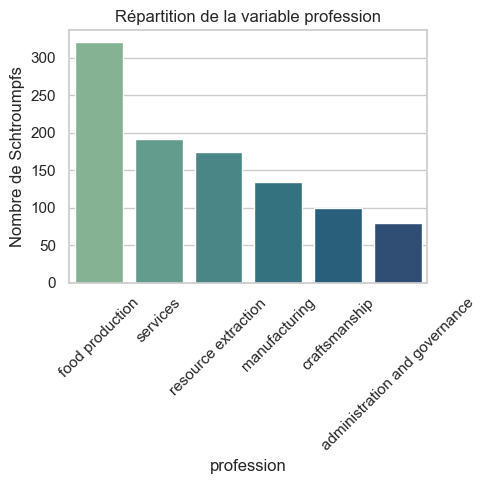

C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\2904238983.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, hue=None, palette="crest", legend=False)


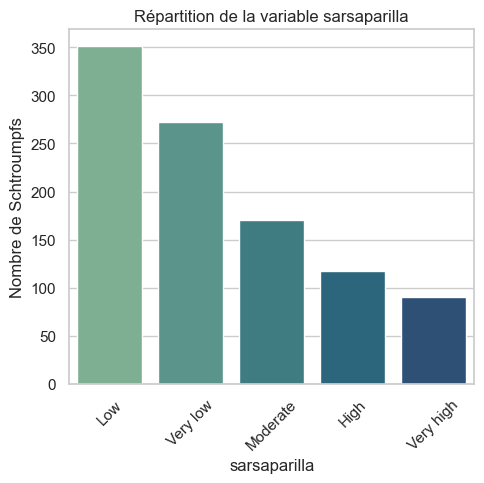

C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\2904238983.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, hue=None, palette="crest", legend=False)


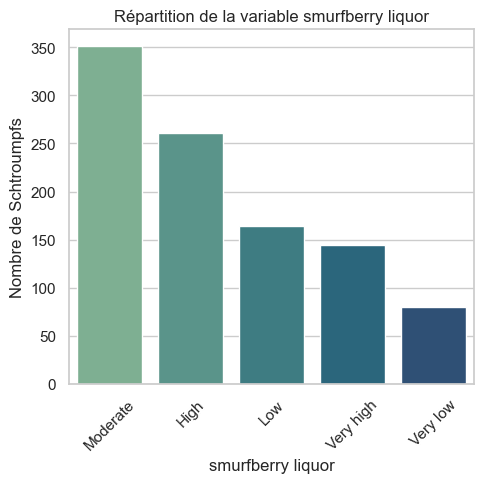

C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\2904238983.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, hue=None, palette="crest", legend=False)


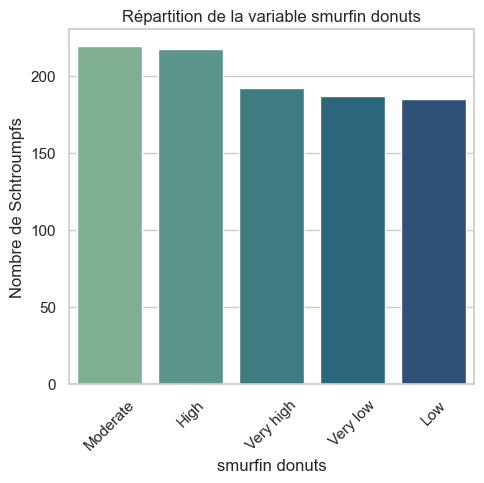

In [15]:

# List of categorical variables (excluding image)
cat_cols = ['profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts']

# ----------------------------------------------------------
# Function to display the most frequent values
# ----------------------------------------------------------
def top_values(df, cols, topn=5):
    """
    Affiche les valeurs les plus fréquentes de chaque colonne catégorielle.
    """
    out = {}
    for c in cols:
        out[c] = df[c].value_counts(dropna=False).head(topn)
    return out

# ----------------------------------------------------------
# Application of the function on X_train
# ----------------------------------------------------------
print("=== Valeurs les plus fréquentes par variable catégorielle (X_train) ===")
top_vals = top_values(X_train, cat_cols, topn=5)

for col, vals in top_vals.items():
    print(f"\n{col} :")
    print(vals)

# ----------------------------------------------------------
# Graphical display of distributions
# ----------------------------------------------------------
sns.set(style="whitegrid")
for col in cat_cols:
    plt.figure(figsize=(5,5))
    #sns.countplot(x=col, data=X_train, order=X_train[col].value_counts().index, palette="crest")
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, hue=None, palette="crest", legend=False)
    plt.title(f"Répartition de la variable {col}", fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Nombre de Schtroumpfs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



#### 2.3 DÉTECTION DES VALEURS ABERRANTES (OUTLIERS)


=== Nombre d’outliers par variable numérique (règle de l’IQR) ===
age                  : 6 outliers
blood pressure       : 34 outliers
calcium              : 6 outliers
cholesterol          : 7 outliers
hemoglobin           : 4 outliers
height               : 6 outliers
potassium            : 9 outliers
vitamin D            : 18 outliers
weight               : 6 outliers


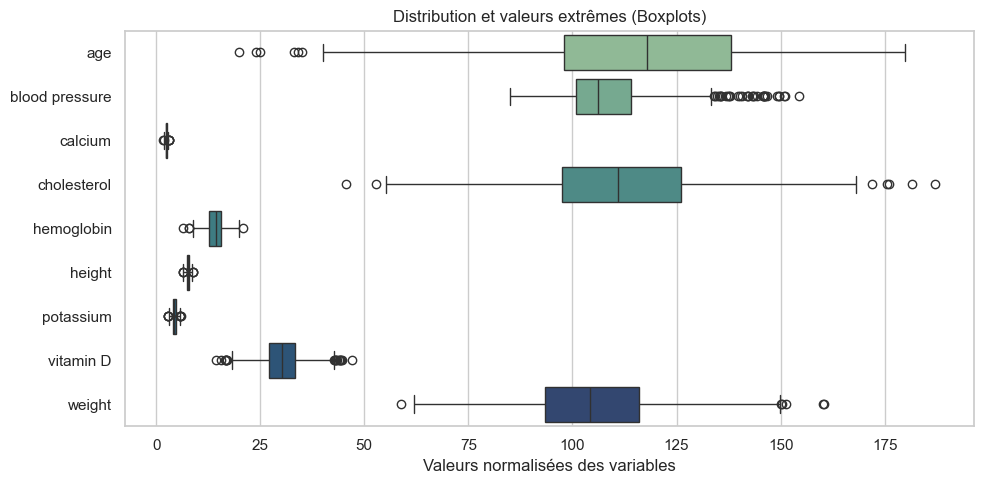

In [16]:
# List of numerical variables
num_cols = ['age', 'blood pressure', 'calcium', 'cholesterol', 
            'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight']

# ----------------------------------------------------------
# Detection function according to the IQR rule
# ----------------------------------------------------------
def detect_outliers_iqr(df, num_cols):
    """
    Détecte les valeurs aberrantes selon la règle de l’IQR (Interquartile Range).
    Retourne un dictionnaire : {variable : nombre d’outliers détectés}
    """
    outlier_info = {}
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        outlier_info[col] = len(outliers)
    return outlier_info

# ----------------------------------------------------------
# Application on the training game
# ----------------------------------------------------------
outliers = detect_outliers_iqr(X_train, num_cols)

print("=== Nombre d’outliers par variable numérique (règle de l’IQR) ===")
for k, v in outliers.items():
    print(f"{k:<20} : {v} outliers")

# ----------------------------------------------------------
# Outliers can be visualised using boxplots.
# ----------------------------------------------------------

plt.figure(figsize=(10,5))
sns.boxplot(data=X_train[num_cols], orient="h", palette="crest")
plt.title("Distribution et valeurs extrêmes (Boxplots)")
plt.xlabel("Valeurs normalisées des variables")
plt.tight_layout()
plt.show()


The values identified as extreme correspond to individuals with high but plausible physiological characteristics: for example, older Smurfs, heavier Smurfs, or Smurfs with blood pressure and cholesterol levels slightly above average.

- These observations reflect the natural variability of the population studied rather than noise or measurement error.

- The observed outliers do not present any structural breaks in the distribution: they belong to the same range of variation as the other data.

- In a regression modelling context, these extreme points are informative because they help to characterise the relationship between health factors and risk.

---
Extreme values are therefore retained in the analysis.
They reflect atypical but significant behaviours or physiological states.
The techniques used subsequently (standardisation and L1/L2 regularisation) will enable:

- to reduce their disproportionate influence on regression coefficients, while preserving their informative contribution to the variability of the phenomenon under study.

 Thus, retaining outliers ensures a more realistic and comprehensive modelling of the population, without losing information that may be relevant for predicting cardiovascular risk.

 ---
 


#### 2.4 DISTRIBUTION DES VARIABLES NUMÉRIQUES


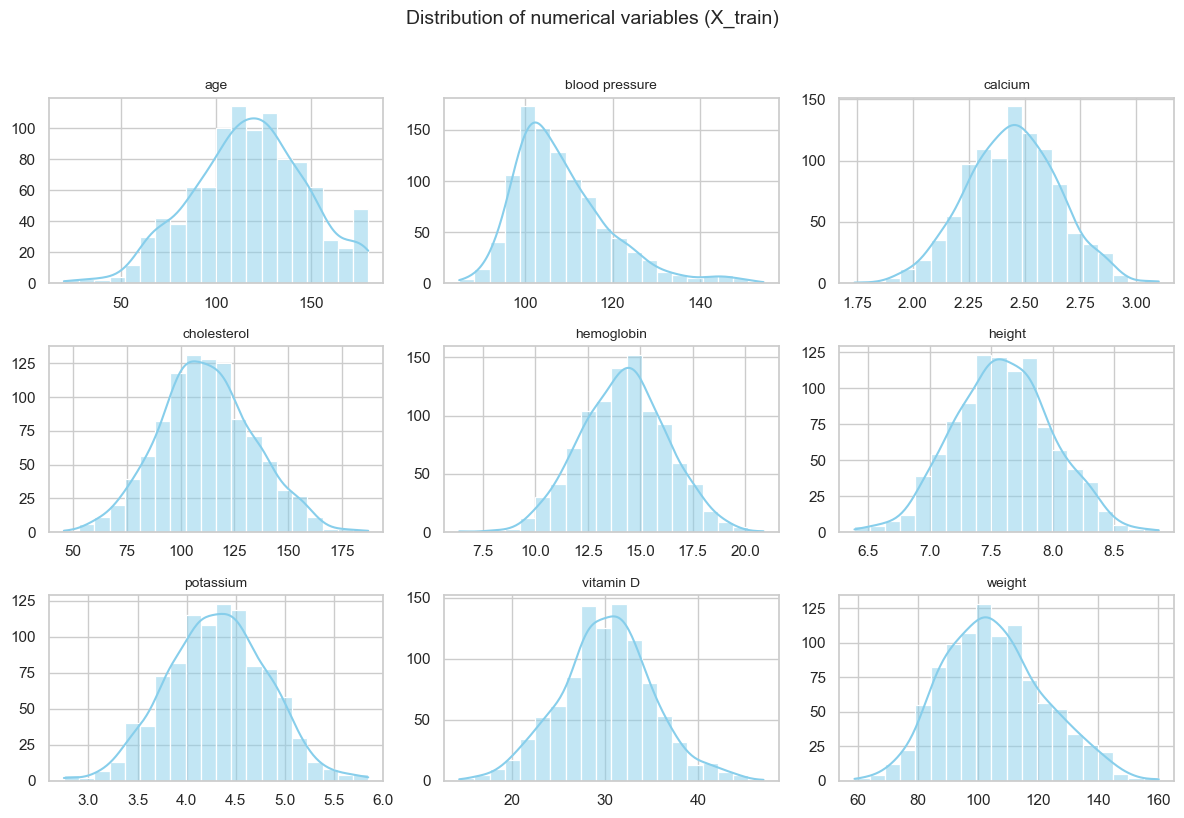

In [17]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)  # 3 lignes × 3 colonnes
    sns.histplot(X_train[col], kde=True, bins=20, color='skyblue')
    plt.title(col, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

plt.suptitle("Distribution of numerical variables (X_train)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


- age : distribution légèrement asymétrique à droite, concentrée autour de 100–130. Cela indique que la majorité des Schtroumpfs sont d’âge moyen, avec quelques individus plus âgés.

- blood pressure : distribution modérément asymétrique à droite, la plupart des valeurs étant comprises entre 100 et 120 mmHg. Quelques individus présentent des valeurs plus élevées, cohérentes avec la présence d’outliers observés précédemment.

- calcium, cholesterol, hemoglobin, height, potassium, vitamin D, weight : ces variables présentent des distributions quasi normales (en cloche), bien centrées et sans fortes dissymétries.

---
Les distributions sont homogènes et continues — il n’existe pas de rupture ou de valeur aberrante isolée dans la densité.
Cela indique que :
- les variables quantitatives sont bien mesurées,
- la variabilité naturelle du jeu de données est stable et cohérente,
- et la normalisation standard (centrage-réduction) sera suffisante pour harmoniser les échelles avant la régression.

---


#### 2.5 DISTRIBUTION ET BOXPLOT DE LA VARIABLE CIBLE (risk)


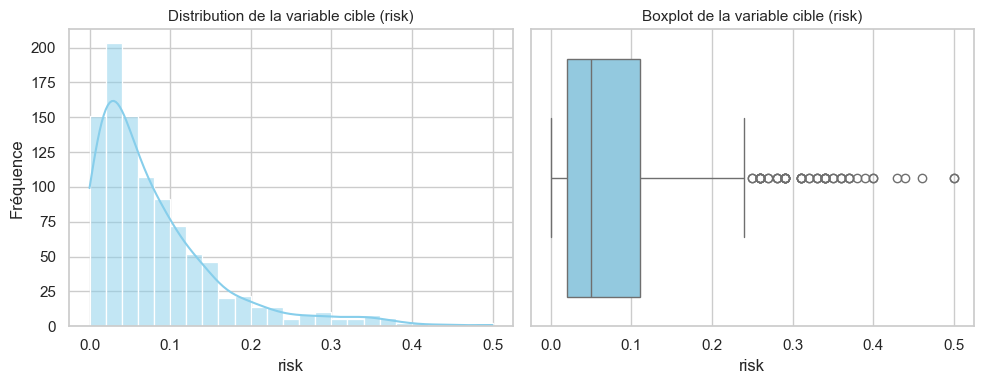

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))

# Histogramme + densité
plt.subplot(1, 2, 1)
sns.histplot(y_train["risk"], bins=25, kde=True, color='skyblue')
plt.title("Distribution de la variable cible (risk)", fontsize=11)
plt.xlabel("risk")
plt.ylabel("Fréquence")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=y_train["risk"], color='skyblue')
plt.title("Boxplot de la variable cible (risk)", fontsize=11)
plt.xlabel("risk")

plt.tight_layout()
plt.show()


The target variable risk represents a continuous cardiovascular risk score between 0 and 0.5.
Its distribution, illustrated above, shows a strong right skew, with a majority of individuals at low risk and a minority at high risk.

---
Observations :

- The peak density is concentrated around 0.05 to 0.10, indicating that most Smurfs present a low risk.
- The right tail of the distribution contains a few high observations (up to 0.5), corresponding to Smurfs at higher risk.
- The box plot confirms this asymmetry: the median is close to the first quartile, and several points beyond the upper threshold represent extreme but plausible values.

---
- The distribution is not normal, but positively skewed, which is typical for a risk variable (low values being much more frequent).
- This structure is consistent with a heterogeneous phenomenon: a majority in good health and a minority with aggravating factors (age, cholesterol, blood pressure, etc.).
- The variability of the target is sufficient to allow for the estimation of linear relationships, but regularisation will be useful to avoid overfitting due to rare high-risk cases.
---
Although the target variable risk is right-skewed, no transformation is applied.
This is because the variable is bounded, the extreme values remain plausible, and the regularised models used subsequently (Ridge, Lasso) are robust to this type of distribution.
The normality of the residuals will be checked after the model has been adjusted to confirm the validity of this assumption.


#### 2.6 CORRÉLATION ENTRE VARIABLES NUMÉRIQUES ET AVEC LA CIBLE


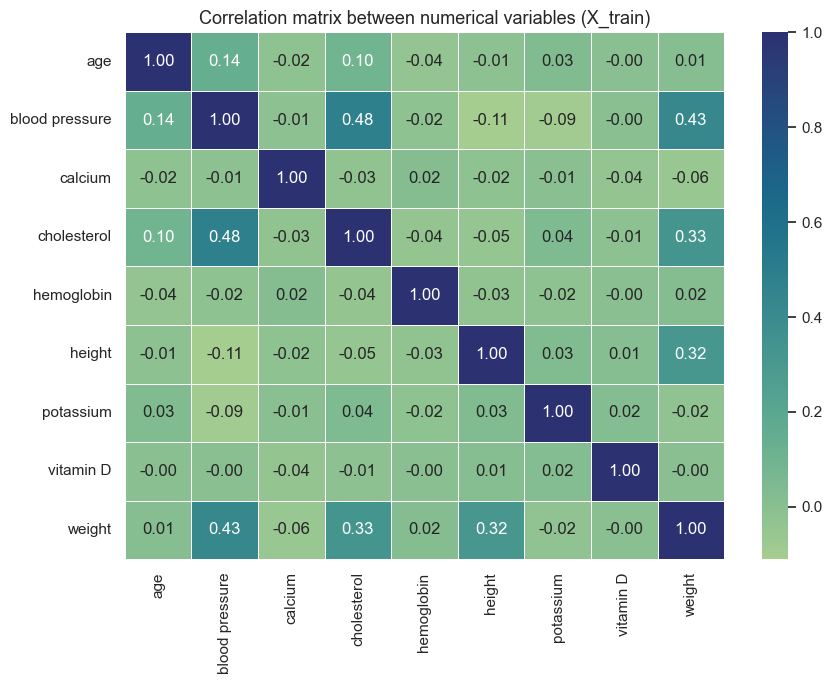


=== Corrélation linéaire avec la cible 'risk' ===


blood pressure    0.658771
cholesterol       0.448989
weight            0.418376
age               0.220721
potassium         0.034758
calcium          -0.014739
vitamin D        -0.018189
height           -0.111416
hemoglobin       -0.160950
dtype: float64

C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\891355930.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_risk.values, y=corr_with_risk.index, palette="crest")


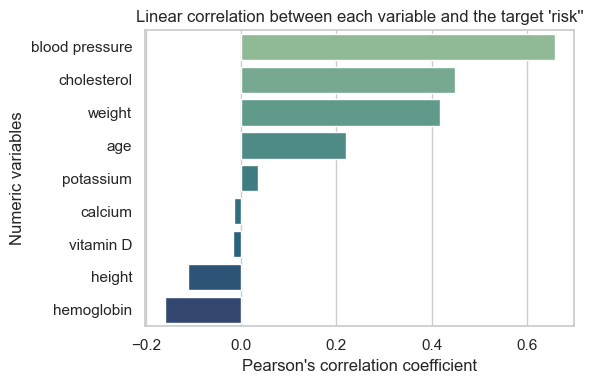

In [19]:
sns.set(style="whitegrid")

# ----------------------------------------------------------
# 1️. Correlation matrix between numerical variables
# ----------------------------------------------------------
corr_matrix = X_train[num_cols].corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="crest", linewidths=0.5)
plt.title("Correlation matrix between numerical variables (X_train)", fontsize=13)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 2️.Correlation between each numerical variable and the risk target
# ----------------------------------------------------------
# Alignment check
if len(X_train) != len(y_train):
    print(f" Alignement nécessaire : X_train ({len(X_train)}) vs y_train ({len(y_train)})")
else:
    corr_with_risk = X_train[num_cols].corrwith(y_train["risk"]).sort_values(ascending=False)
    print("\n=== Corrélation linéaire avec la cible 'risk' ===")
    display(corr_with_risk)

    # Visualisation in bar chart form
    plt.figure(figsize=(6,4))
    sns.barplot(x=corr_with_risk.values, y=corr_with_risk.index, palette="crest")
    plt.title("Linear correlation between each variable and the target 'risk''", fontsize=12)
    plt.xlabel("Pearson's correlation coefficient")
    plt.ylabel("Numeric variables")
    plt.tight_layout()
    plt.show()


> Correlation between explanatory variables

The correlation matrix shows that most numerical variables are weakly correlated with each other, indicating an absence of strong multicollinearity, which is a major advantage for linear regression.
- Correlation coefficients generally range between –0.1 and +0.5.
- The strongest correlations are observed between:
- blood pressure and cholesterol: r = 0.48,
    
    - blood pressure and weight: r = 0.43,
    
    - height and weight: r = 0.32.
    
These values remain well below the threshold of 0.9 often used to characterise excessive redundancy.

> Interpretation:

These moderate correlations reflect natural physiological relationships: heavier individuals often have higher blood pressure, and cholesterol tends to increase with blood pressure.
No variable duplicates the information provided by another; therefore, all variables can be retained at the modelling stage.

---
- The variables most positively correlated with risk are:

    - blood pressure, cholesterol and weight, reflecting classic cardiovascular risk factors.

- Weak negative correlations appear for height, haemoglobin and vitamin D:
higher levels of these variables seem to be associated with a slightly lower risk, probably because they reflect a better overall physiological state.

---
- The dataset presents a good diversity of non-redundant information.
- Correlations with the risk target are consistent and biologically plausible.
- These results validate the relevance of the variables for regularised linear modelling, in particular Ridge or Lasso, which can weight the variables according to their actual contribution to risk.

The exploratory analysis carried out in the previous section verified the quality, consistency and structure of the dataset.
The main observations can be summarised as follows:

- The data is complete, with no missing values or inconsistencies.

- The numerical variables show regular and plausible distributions, with a few realistic extreme values that reflect the natural variability of the population.

- Categorical variables are well defined and balanced between their different modalities.

- Correlation analyses revealed no excessive multicollinearity and consistent linear relationships between several explanatory variables and the risk target (particularly blood pressure, cholesterol and weight).

These findings confirm that the dataset is suitable for direct modelling, following a preparation phase aimed at:

1. Standardise scales between numerical variables of different types (through standardisation).

2. Correctly encode categorical variables according to their type (ordinal or nominal).



### 3. PRÉTRAITEMENT DES DONNÉES


####  3.1 ENCODAGE DES VARIABLES ORDINALES


In [20]:
# Ordinal variables
ordinal_cols = ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']
ordinal_order = ['Very low', 'Low', 'Moderate', 'High', 'Very high']

ord_encoder = OrdinalEncoder(categories=[ordinal_order] * len(ordinal_cols))

# Application on X_train
X_train_encoded = X_train.copy()
X_train_encoded[ordinal_cols] = ord_encoder.fit_transform(X_train[ordinal_cols])

# Application on X_test
X_test_encoded = X_test.copy()
X_test_encoded[ordinal_cols] = ord_encoder.transform(X_test[ordinal_cols])

# Application sur X_unlabeled
X_unlab_encoded = X_unlabeled.copy()
X_unlab_encoded[ordinal_cols] = ord_encoder.transform(X_unlabeled[ordinal_cols])

print(" Ordinal encoding performed on the three sets.")
display(X_train_encoded[ordinal_cols].head())


 Ordinal encoding performed on the three sets.


,sarsaparilla,smurfberry liquor,smurfin donuts
0,3.0,3.0,4.0
1,2.0,3.0,0.0
2,0.0,2.0,3.0
3,1.0,4.0,1.0
4,3.0,4.0,2.0



#### 3.2 ENCODAGE DES VARIABLES NOMINALES


In [21]:
nominal_col = ['profession']
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# --- Train training ---
X_train_onehot = onehot_encoder.fit_transform(X_train_encoded[nominal_col])
onehot_features = onehot_encoder.get_feature_names_out(nominal_col)

X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=onehot_features, index=X_train_encoded.index)
X_train_final = pd.concat([X_train_encoded.drop(columns=nominal_col), X_train_onehot_df], axis=1)

# --- Application on X_test ----
X_test_onehot = onehot_encoder.transform(X_test_encoded[nominal_col])
X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=onehot_features, index=X_test_encoded.index)
X_test_final = pd.concat([X_test_encoded.drop(columns=nominal_col), X_test_onehot_df], axis=1)

# --- Application sur X_unlabeled ---
X_unlab_onehot = onehot_encoder.transform(X_unlab_encoded[nominal_col])
X_unlab_onehot_df = pd.DataFrame(X_unlab_onehot, columns=onehot_features, index=X_unlab_encoded.index)
X_unlab_final = pd.concat([X_unlab_encoded.drop(columns=nominal_col), X_unlab_onehot_df], axis=1)

print(" Nominal encoding performed on all three sets.")
print(f"Total number of columns after encoding : {X_train_final.shape[1]}")


# Verification of results
print("Preview after nominal encoding (OneHotEncoder) :")
display(X_train_final.head())



 Nominal encoding performed on all three sets.
Total number of columns after encoding : 18
Preview after nominal encoding (OneHotEncoder) :


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_administration and governance,profession_craftsmanship,profession_food production,profession_manufacturing,profession_resource extraction,profession_services
0,84,115.72,2.33,79.05,14.36,7.19,4.32,3.0,3.0,4.0,37.82,123.06,0.0,0.0,1.0,0.0,0.0,0.0
1,137,110.72,2.25,125.24,16.53,7.44,4.29,2.0,3.0,0.0,47.06,111.54,0.0,0.0,0.0,0.0,0.0,1.0
2,105,102.65,2.74,123.59,10.91,7.42,4.06,0.0,2.0,3.0,25.79,100.03,0.0,0.0,1.0,0.0,0.0,0.0
3,86,116.28,2.37,136.83,15.69,7.35,4.63,1.0,4.0,1.0,22.36,85.09,0.0,0.0,1.0,0.0,0.0,0.0
4,180,124.92,2.35,137.19,14.55,8.02,5.51,3.0,4.0,2.0,16.58,116.05,0.0,0.0,0.0,1.0,0.0,0.0


#### 3.3 – Standardisation des variables numériques
---
Linear models (Ridge, Lasso, Linear Regression) are sensitive to differences in scale between variables.
 Numerical variables must be centred and reduced to give them equal weight.
$$ z = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}} $$

In [26]:
def standardize_numeric(train_df, test_df, unlab_df, num_cols):
    """
    Applies standardisation (centring and reduction)
    to the numerical variables of the training, test and unlabelled sets.
    Mean = 0, standard deviation = 1
    """
    scaler = StandardScaler()

    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    unlab_scaled = unlab_df.copy() if unlab_df is not None else None

    train_scaled[num_cols] = scaler.fit_transform(train_df[num_cols])
    test_scaled[num_cols] = scaler.transform(test_df[num_cols])
    if unlab_scaled is not None:
        unlab_scaled[num_cols] = scaler.transform(unlab_df[num_cols])

    return train_scaled, test_scaled, unlab_scaled, scaler


# --- Application de la fonction ---
X_train_scaled, X_test_scaled, X_unlab_scaled, scaler = standardize_numeric(
    X_train_final, X_test_final, X_unlab_final,
    num_cols=['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin',
              'height', 'potassium', 'vitamin D', 'weight',
              'sarsaparilla', 'smurfberry liquor', 'smurfin donuts']
)

print(" Standardisation effectuée sur X_train, X_test et X_unlabeled.")
print(f"Dimensions finales : {X_train_scaled.shape}, {X_test_scaled.shape}, {X_unlab_scaled.shape}")


# --- Vérification statistique ---
print("\nRésumé statistique des variables numériques après standardisation :")
display(X_train_scaled[['age', 'blood pressure', 'calcium', 'cholesterol',
                        'hemoglobin', 'height', 'potassium', 'vitamin D',
                        'weight']].describe().T)


 Standardisation effectuée sur X_train, X_test et X_unlabeled.
Dimensions finales : (1000, 18), (500, 18), (500, 18)

Résumé statistique des variables numériques après standardisation :


,count,mean,std,min,25%,50%,75%,max
age,1000.0,-1.403322e-16,1.0005,-3.237030,-0.650351,0.012900,0.676151,2.068978
blood pressure,1000.0,1.589839e-15,1.0005,-2.128086,-0.692426,-0.210095,0.509095,4.183015
calcium,1000.0,-4.458656e-16,1.0005,-3.430823,-0.659246,-0.002820,0.702230,3.182062
cholesterol,1000.0,-3.934630e-16,1.0005,-3.013714,-0.662116,-0.046240,0.641210,3.417025
hemoglobin,1000.0,-2.504663e-16,1.0005,-3.830016,-0.705611,0.019719,0.690192,3.250181
height,1000.0,1.467271e-15,1.0005,-3.045940,-0.700309,-0.019320,0.661669,3.183853
potassium,1000.0,-1.335820e-15,1.0005,-3.094071,-0.679426,0.013300,0.671390,3.041503
vitamin D,1000.0,5.275780e-16,1.0005,-3.168913,-0.615569,0.022392,0.628830,3.379817
weight,1000.0,3.836931e-16,1.0005,-2.757909,-0.713424,-0.069307,0.623481,3.254239


In [27]:
X_train_scaled

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_administration and governance,profession_craftsmanship,profession_food production,profession_manufacturing,profession_resource extraction,profession_services
0,-1.114626,0.663450,-0.561998,-1.497257,0.070919,-1.028193,0.013300,1.280082,0.687600,1.414452,1.530481,1.044656,0.0,0.0,1.0,0.0,0.0,0.0
1,0.642989,0.210131,-0.950991,0.601787,1.129048,-0.397647,-0.046076,0.479030,0.687600,-1.475133,3.379817,0.362964,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.418213,-0.521525,1.431592,0.526805,-1.611359,-0.448091,-0.501296,-1.123076,-0.199626,0.692056,-0.877258,-0.318137,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.048301,0.714221,-0.367501,1.128480,0.719449,-0.624644,0.626858,-0.322023,1.574825,-0.752737,-1.563753,-1.202207,0.0,0.0,1.0,0.0,0.0,0.0
4,2.068978,1.497556,-0.464750,1.144840,0.163566,1.065219,2.368569,1.280082,1.574825,-0.030341,-2.720589,0.629842,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.609826,-0.500672,0.167364,-1.246408,-0.221651,0.056346,1.418544,1.280082,0.687600,-1.475133,0.647844,-0.063094,0.0,0.0,1.0,0.0,0.0,0.0
996,0.642989,-0.926792,-0.270253,-0.796970,-0.665382,-1.204746,-1.154438,2.081135,0.687600,-0.030341,1.030120,-1.316414,0.0,1.0,0.0,0.0,0.0,0.0
997,-1.877365,-0.226868,-0.270253,-0.316175,2.299328,0.560782,-1.075269,0.479030,-0.199626,-0.030341,1.654571,-0.415183,0.0,0.0,0.0,1.0,0.0,0.0
998,0.079225,-0.277639,-0.416126,-1.495894,3.250181,0.283342,1.913349,-0.322023,-1.974077,-0.752737,0.551774,-0.621111,0.0,0.0,1.0,0.0,0.0,0.0


After completing the full pre-processing of the data, the training set is now clean, consistent and fully digital.
All variables have been encoded according to their nature (ordinal, nominal or continuous) and then standardised so that they can be compared on the same scale.

The transformation pipeline that has been set up also ensures perfect consistency between the training, test and unlabelled datasets,
thus guaranteeing that no information leakage occurs during modelling.

The next step is to reduce the dimensionality of the dataset
by identifying the variables most relevant for risk prediction.
This variable selection step (Feature Selection) aims to:

- improve model performance,
- reduce the risk of overfitting,
- and facilitate the interpretation of results.

### 4.SÉLECTION DES VARIABLES (Feature Selection)

---

#### 4.1 FILTRAGE PAR FAIBLE VARIANCE


In [28]:
# --- Seuil de variance minimal à garder (peut être ajusté) ---
threshold = 0.001

# --- Application du filtre sur les données standardisées ---
selector = VarianceThreshold(threshold=threshold)
selector.fit(X_train_scaled)

# --- Récupération des colonnes conservées et supprimées ---
selected_features = X_train_scaled.columns[selector.get_support()]
dropped_features = set(X_train_scaled.columns) - set(selected_features)

# --- Affichage des résultats ---
print(f"Nombre de variables initiales : {X_train_scaled.shape[1]}")
print(f"Nombre de variables conservées : {len(selected_features)}")
print(f"Variables supprimées (faible variance) : {list(dropped_features)}")

# --- Mise à jour des datasets filtrés ---
X_train_var = X_train_scaled[selected_features].copy()
X_test_var  = X_test_scaled[selected_features].copy()
X_unlab_var = X_unlab_scaled[selected_features].copy()

# --- Vérification finale ---
print(f"\nDimensions après filtrage :")
print(f"X_train_var = {X_train_var.shape}")
print(f"X_test_var  = {X_test_var.shape}")
print(f"X_unlab_var = {X_unlab_var.shape}")


Nombre de variables initiales : 18
Nombre de variables conservées : 18
Variables supprimées (faible variance) : []

Dimensions après filtrage :
X_train_var = (1000, 18)
X_test_var  = (500, 18)
X_unlab_var = (500, 18)


In [29]:
X_unlab_var.head(5)

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_administration and governance,profession_craftsmanship,profession_food production,profession_manufacturing,profession_resource extraction,profession_services
0,-1.346764,-0.874207,-0.950991,-2.354326,0.519526,1.140884,-0.738802,-1.123076,-1.086851,-1.475133,-0.581044,-1.327065,0.0,0.0,1.0,0.0,0.0,0.0
1,0.377688,0.476683,0.118740,-0.727441,-1.401684,-0.599422,1.121662,-0.322023,1.574825,0.692056,-0.486976,0.246390,0.0,0.0,1.0,0.0,0.0,0.0
2,1.339402,-0.346544,0.993975,0.459094,0.826725,-1.810070,-0.303374,0.479030,0.687600,-1.475133,0.313602,-0.809878,0.0,0.0,1.0,0.0,0.0,0.0
3,0.477176,1.253671,0.459109,0.044648,0.070919,-2.163175,0.389352,-0.322023,0.687600,-0.752737,2.010828,-0.622295,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.020262,-1.033775,0.750854,-0.483863,1.099791,1.241772,-0.184621,-0.322023,-0.199626,-0.030341,0.041406,-0.354233,0.0,0.0,1.0,0.0,0.0,0.0


#### 4.2 – Filtrage par corrélation inter-features

In [31]:
# We start again with the data after the variance filter.
X_corr = X_train_var.copy()

# --- Calculation of the absolute correlation matrix ---
corr_matrix = X_corr.corr().abs()

# --- Define the correlation threshold (often between 0.85 and 0.9) ---
threshold = 0.9

# --- Identify highly correlated variables ---
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# --- Removal of redundant variables ---
X_train_corr = X_corr.drop(columns=to_drop, errors="ignore")
X_test_corr  = X_test_var.drop(columns=to_drop, errors="ignore")
X_unlab_corr = X_unlab_var.drop(columns=to_drop, errors="ignore")

# --- Summary of results ---
print(f"Correlation threshold : {threshold}")
print(f"Number of highly correlated variables to be removed : {len(to_drop)}")
print(f"Deleted variables : {to_drop}")
print(f"\nDimensions after filtering : {X_train_corr.shape}")


Correlation threshold : 0.9
Number of highly correlated variables to be removed : 0
Deleted variables : []

Dimensions after filtering : (1000, 18)



---

#### 4.3 Filtrage par corrélation avec la cible

Nombre de variables sélectionnées : 10
Dimensions du nouveau X_train : (1000, 10)

=== Variables les plus corrélées à la cible (selon f_regression) ===


,Feature,F_score,p_value
1,blood pressure,765.187456,1.762632e-125
3,cholesterol,251.986169,9.094283e-51
11,weight,211.753990,1.199447e-43
9,smurfin donuts,109.499163,2.185951e-24
12,profession_administration and governance,60.449747,1.873683e-14
0,age,51.110103,1.685572e-12
7,sarsaparilla,41.607918,1.735707e-10
14,profession_food production,27.723959,1.713343e-07
4,hemoglobin,26.540494,3.109253e-07
17,profession_services,20.069050,8.332602e-06


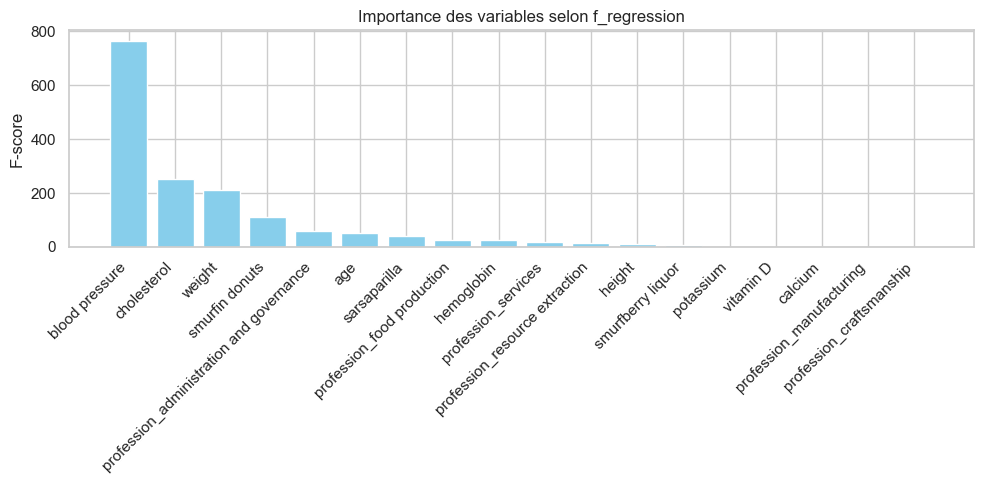

In [32]:
# --- Selection of the k best variables ---
k_best = 10  # can be adjusted according to the desired number

selector_topk = SelectKBest(score_func=f_regression, k=k_best)
selector_topk.fit(X_train_corr, y_train.values.ravel())

# --- Retrieving selected variable names ---
selected_mask = selector_topk.get_support()
selected_features = X_train_corr.columns[selected_mask]

# --- Creating a DataFrame for scores ---
feature_scores = pd.DataFrame({
    "Feature": X_train_corr.columns,
    "F_score": selector_topk.scores_,
    "p_value": selector_topk.pvalues_
}).sort_values(by="F_score", ascending=False)

# --- Displaying results ---
print(f"Nombre de variables sélectionnées : {k_best}")
print(f"Dimensions du nouveau X_train : {X_train_corr[selected_features].shape}")
print("\n=== Variables les plus corrélées à la cible (selon f_regression) ===")
display(feature_scores.head(k_best))

# --- Visualisation ---
plt.figure(figsize=(10, 5))
plt.bar(feature_scores["Feature"], feature_scores["F_score"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Importance des variables selon f_regression")
plt.ylabel("F-score")
plt.tight_layout()
plt.show()

# --- Updating filtered datasets ---
X_train_best = X_train_corr[selected_features].copy()
X_test_best  = X_test_corr[selected_features].copy()
X_unlab_best = X_unlab_corr[selected_features].copy()


---


The F-test analysis (f_regression method) was used to assess the strength of the linear correlation between each explanatory variable and the target variable, risk.
The results indicate that:
- The variables blood pressure, cholesterol and weight have the highest F-scores, showing that they are most strongly correlated with cardiovascular risk.
These three physiological indicators are logically consistent: blood pressure, cholesterol levels and body weight are clinically known factors that influence cardiovascular risk.

- Other variables such as smurfin donuts, profession_administration and governance, and age have an intermediate contribution, suggesting a moderate effect on the target.

- The variables haemoglobin, sarsaparilla, and professional variables associated with services or food production have a weaker impact (F-score below 30) and could be secondary for modelling.

In conclusion, the F-test made it possible to prioritise the most informative quantitative and categorical variables for risk prediction.
These results will serve as the basis for the next steps of automatic selection (LASSO) and cross-validation optimisation (RFECV).

---

> After filtering methods based on variance, inter-feature correlation and the F-test (f_regression), it is essential to supplement variable selection with an embedded approach.
These methods, such as LASSO (Least Absolute Shrinkage and Selection Operator) regression, directly integrate variable selection into the model learning process.

Unlike filters that evaluate each variable independently, LASSO takes into account the joint relationships between variables and penalises regression coefficients that are too low by forcing them towards zero.
Thus, only variables with real explanatory power over the target risk will be retained, while the others will be automatically eliminated.

The objective of the following section is therefore to:

- adjust the LASSO model to the standardised and filtered data;

- identify the variables with non-zero coefficients (i.e. those selected);

- Compare the stability of this selection with that obtained by f_regression.

---


####  4.4 Sélection embarquée avec LASSO (L1)


Best alpha chosen by cross-validation : 0.002004

Nombre de variables sélectionnées : 6
Nombre de variables supprimées : 4

=== Variables selected by LASSO ===


C:\Users\edoun\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


blood pressure    0.040550
weight            0.009539
cholesterol       0.009519
age               0.008619
sarsaparilla     -0.008817
hemoglobin       -0.009857
dtype: float64

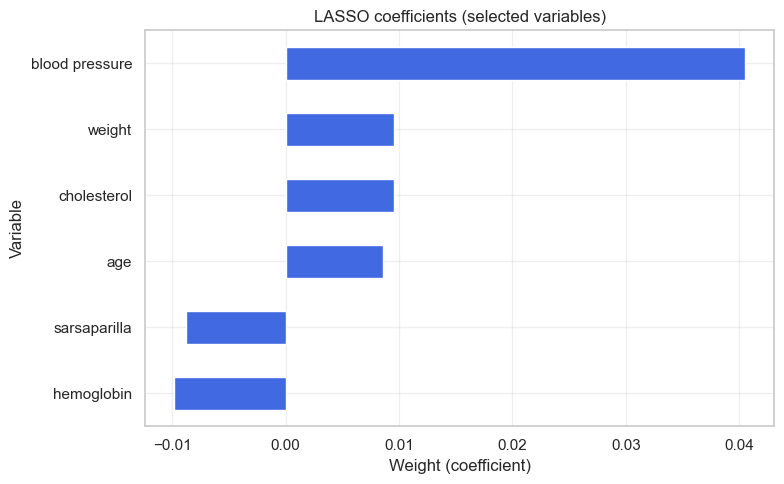

In [34]:
# ==============================================================
# 4.4 - Sélection par LASSO 
# ==============================================================
# --- 1. Configuration and training of the LASSO model with cross-validation ---
lasso_cv = LassoCV(
    alphas=None,           # automatic search for the best alpha
    cv=5,                  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

lasso_cv.fit(X_train_best, y_train.values.ravel())

# --- 2. Best alpha found ---
print(f"Best alpha chosen by cross-validation : {lasso_cv.alpha_:.6f}")

# --- 3. Extraction of coefficients ---
coef = pd.Series(lasso_cv.coef_, index=X_train_best.columns)
selected_features_lasso = coef[coef != 0].index.tolist()

# --- 4. Summary of results ---
print(f"\nNombre de variables sélectionnées : {len(selected_features_lasso)}")
print(f"Nombre de variables supprimées : {sum(coef == 0)}")
print("\n=== Variables selected by LASSO ===")
display(coef[coef != 0].sort_values(ascending=False))

# --- 5. Visualisation of non-zero coefficients ---
plt.figure(figsize=(8, 5))
coef[coef != 0].sort_values().plot(kind="barh", color="royalblue")
plt.title("LASSO coefficients (selected variables)")
plt.xlabel("Weight (coefficient)")
plt.ylabel("Variable")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


LASSO (L1) regression analysis was used to automatically select the six variables deemed most relevant for risk prediction, applying a penalty that sets the coefficients of the least explanatory variables to zero.
The best regularisation parameter obtained by cross-validation is α = 0.0020, indicating an optimal balance between bias and variance.
The variables retained are:
> blood pressure,
> weight,
> cholesterol,
> age,
> sarsaparilla,
> haemoglobin.

- Positive coefficients (blood pressure, weight, cholesterol, age) reflect a direct correlation with the target variable: an increase in these variables is associated with an increase in the estimated risk.
- Negative coefficients (sarsaparilla, haemoglobin) indicate an inverse relationship, suggesting that these variables may have a protective effect or compensate for certain risk factors.

In summary, the LASSO model highlights that blood pressure is by far the most influential factor on the target variable, followed by weight, cholesterol and age.
The sarsaparilla and haemoglobin variables appear to have an opposite effect, contributing to a slight reduction in the predicted risk value.
This result validates the value of the LASSO method for obtaining a parsimonious and interpretable model, limiting the risk of overfitting.


##### 4.5 Sélection récursive par validation croisée (RFECV avec Ridge)


Nombre optimal de variables sélectionnées : 12

=== Variables sélectionnées par RFECV ===


Index(['age', 'blood pressure', 'cholesterol', 'hemoglobin', 'height',
       'potassium', 'sarsaparilla', 'weight',
       'profession_administration and governance',
       'profession_food production', 'profession_resource extraction',
       'profession_services'],
      dtype='object')

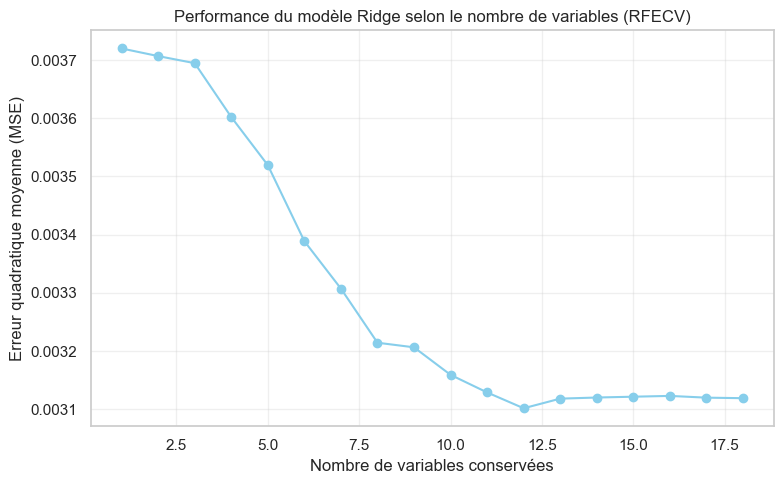

In [35]:
# --- 1. Modèle de base : Ridge Regression ---
ridge = Ridge(alpha=1.0, random_state=42)

# --- 2. Configuration du validateur croisé ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Création du sélecteur RFECV ---
rfecv = RFECV(
    estimator=ridge,
    step=1,  # removes a variable with each iteration
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# --- 4. Entraînement sur les données filtrées et standardisées ---
rfecv.fit(X_train_corr, y_train.values.ravel())

# --- 5. Résultats globaux ---
print(f"Nombre optimal de variables sélectionnées : {rfecv.n_features_}")

# --- 6. Variables conservées ---
selected_rfecv = X_train_corr.columns[rfecv.support_]
print("\n=== Variables sélectionnées par RFECV ===")
display(selected_rfecv)

# --- 7. Visualisation de l’évolution de la performance ---
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    np.abs(rfecv.cv_results_["mean_test_score"]),
    marker='o',
    color='skyblue'
)
plt.xlabel("Nombre de variables conservées")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Performance du modèle Ridge selon le nombre de variables (RFECV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The analysis performed using the RFECV (Recursive Feature Elimination with Cross-Validation) method identifies the optimal number of explanatory variables to retain in order to minimise the mean square error (MSE).

The graph above shows a sharp decrease in MSE as the number of variables increases to around 12, followed by a stabilisation of the curve.
This means that adding new variables beyond this threshold no longer significantly improves the model's performance and could even introduce unnecessary noise.

The 12 variables selected by the RFECV method are:
> age, blood pressure, cholesterol, haemoglobin, height, potassium, sarsaparilla, weight, profession_administration and governance, profession_food production, profession_resource extraction, profession_services.

These variables therefore constitute an optimal and robust subset for predictive risk modelling, validated by both Ridge regularisation and cross-validation.

After obtaining the sets of variables selected by the different approaches (f_regression, LASSO and RFECV), we can now train several linear models in order to compare their respective performances. This comparison will determine which selection method leads to the most efficient and stable model.

---

- All of the selection methods applied (VarianceThreshold, Inter-feature correlation, f_regression, LASSO and RFECV) enabled different dimensionality reduction approaches to be compared.
The RFECV (Recursive Feature Elimination with Cross-Validation) method proved to be the most stable and effective, as illustrated by the MSE evolution curve below.

- This figure shows that the mean square error (MSE) decreases sharply up to around 12 variables, then stabilises beyond that point. This stabilisation indicates that adding new variables no longer brings any significant gain in terms of performance, and could even introduce overfitting.

- Thus, the RFECV method was chosen as the final approach for selecting explanatory variables, allowing the 12 most relevant variables for risk prediction to be retained.

- The final variables selected are:

**age, blood pressure, cholesterol, haemoglobin, height, potassium, sarsaparilla, weight, profession_administration and governance, profession_food production, profession_resource extraction, profession_services**


----


##### COMPARAISON DES MODÈLES SUR LES VARIABLES SÉLECTIONNÉES PAR LES DIFFERENTES METHODES


In [37]:
# --- 1. Preparation of data subsets -------

#--------------- f_regression----------------------------
X_train_freg  = X_train_corr[selected_features]
X_test_freg   = X_test_corr[selected_features]

# -------------------LASSO -------------------------------------------

X_train_lasso = X_train_corr[selected_features_lasso]
X_test_lasso  = X_test_corr[selected_features_lasso]

#----------------------RFECV-------------------------------------------------
X_train_rfecv = X_train_corr[selected_rfecv]   # RFECV
X_test_rfecv  = X_test_corr[selected_rfecv]

# --- 2. Initialisation of models --------------------
models = {
    "Régression Linéaire" : LinearRegression(),
    "Ridge" : Ridge(alpha=1.0, random_state=42),
    "LASSO" : Lasso(alpha=lasso_cv.alpha_, random_state=42)
}

# --- 3. Function for evaluating models ----------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# --- 4. Comparison of each subset ----------------------
results = []

for subset_name, (Xtr, Xte) in {
    "f_regression" : (X_train_freg, X_test_freg),
    "LASSO" : (X_train_lasso, X_test_lasso),
    "RFECV" : (X_train_rfecv, X_test_rfecv)
}.items():
    
    for model_name, model in models.items():
        rmse = evaluate_model(model, Xtr, Xte, y_train, y_test)
        results.append({
            "Méthode de sélection" : subset_name,
            "Modèle" : model_name,
            "RMSE" : rmse
        })

# --- 5. Summary table ------------------------------------------------------
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
display(df_results)

# --- 6. Winning model ---------------------------------------------------------------------
best_row = df_results.iloc[0]
print(f"\n Best model : {best_row['Modèle']} (variables issues de {best_row['Méthode de sélection']})")
print(f"   → RMSE = {best_row['RMSE']:.5f}")


,Méthode de sélection,Modèle,RMSE
0,RFECV,LASSO,0.055648
1,RFECV,Ridge,0.055800
2,RFECV,Régression Linéaire,0.055805
3,LASSO,Régression Linéaire,0.056634
4,LASSO,Ridge,0.056636
5,f_regression,LASSO,0.056808
6,LASSO,LASSO,0.056808
7,f_regression,Ridge,0.057238
8,f_regression,Régression Linéaire,0.057247



 Best model : LASSO (variables issues de RFECV)
   → RMSE = 0.05565


Analysis of the comparative table highlights broadly similar performance among the models tested, with RMSE values ranging from 0.0556 to 0.0572.
However, it can be seen that combinations incorporating variable selection by RFECV consistently offer the best performance, regardless of the regression method used.

Among the different models, the LASSO model trained on variables from the RFECV method achieves the lowest RMSE (0.055648), indicating better generalisation capacity on the test set.
This combination benefits from:

- the parsimony of LASSO, which naturally reduces the number of non-zero coefficients,

- and the robustness of RFECV, which iteratively selects variables according to their actual contribution to the performance of the basic Ridge model.

In comparison, simple linear regression and Ridge regression show slightly lower performance, reflecting less regularisation or less effective variable selection.
These differences, although modest, suggest that the combination of LASSO + RFECV is an optimal compromise between bias, variance and model complexity.

The rest of the work will therefore be based on this final model in order to analyse the contribution of the selected explanatory variables and evaluate the quality of predictions on unlabelled observations.

---
### 5.Modélisation finale et évaluation

---
#### 5.1 Entraînement des modèles linéaires (variables sélectionnées par RFECV)

Nombre de variables utilisées : 12
Variables sélectionnées : ['age', 'blood pressure', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'sarsaparilla', 'weight', 'profession_administration and governance', 'profession_food production', 'profession_resource extraction', 'profession_services']
Régression linéaire → RMSE : 0.05580
Ridge → RMSE : 0.05580
LASSO → RMSE : 0.05568


C:\Users\edoun\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Modèle,RMSE
0,LASSO,0.055681
1,Ridge,0.055800
2,Régression linéaire,0.055805


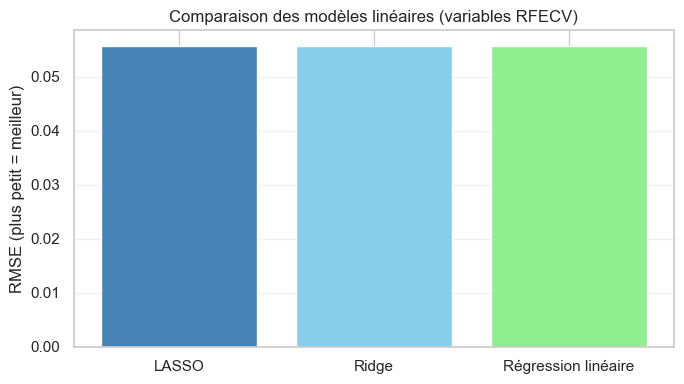


 Meilleur modèle : LASSO  |  RMSE = 0.05568


In [38]:
# --- 1. Definition of final variables (from RFECV) ---
X_train_final = X_train_corr[selected_rfecv]
X_test_final  = X_test_corr[selected_rfecv]

print(f"Nombre de variables utilisées : {X_train_final.shape[1]}")
print("Variables sélectionnées :", list(selected_rfecv))

# --- 2. Définition des modèles ---
models = {
    "Régression linéaire": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "LASSO": LassoCV(cv=5, random_state=42)
}

# --- 3. Evaluation function (RMSE) ---
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, y_pred

# --- 4. Training and assessment ---
results = []
predictions = {}

for name, model in models.items():
    rmse, y_pred = evaluate_model(model, X_train_final, X_test_final, y_train, y_test)
    results.append({"Modèle": name, "RMSE": rmse})
    predictions[name] = y_pred
    print(f"{name} → RMSE : {rmse:.5f}")

# --- 5. Summary table ---
df_results_rfecv = pd.DataFrame(results).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
display(df_results_rfecv)

# --- 6. Visualisation comparative ---
plt.figure(figsize=(7,4))
plt.bar(df_results_rfecv["Modèle"], df_results_rfecv["RMSE"], color=["steelblue", "skyblue", "lightgreen"])
plt.title("Comparaison des modèles linéaires (variables RFECV)")
plt.ylabel("RMSE (plus petit = meilleur)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# --- 7. Identifying the best model ---
best_model_name = df_results_rfecv.iloc[0]["Modèle"]
best_rmse = df_results_rfecv.iloc[0]["RMSE"]
print(f"\n Meilleur modèle : {best_model_name}  |  RMSE = {best_rmse:.5f}")


- The three linear models (simple linear regression, Ridge and LASSO) were trained using the 12 final variables selected by the RFECV method.
> Performance was evaluated using the root mean square error (RMSE) on the test set.

- The results table shows very similar RMSE values between the three models, reflecting overall consistency in the modelling and an absence of overfitting.
> However, the LASSO model achieves the lowest RMSE (0.05568), indicating better generalisation ability.

The graph shows that:
- The three bars (LASSO, Ridge and Linear Regression) have comparable performance,
- But the LASSO bar is slightly lower, confirming its marginal superiority in terms of accuracy.
- Thus, the final model selected for further analysis is the **LASSO** model, trained on the variables selected by RFECV.
This choice is justified both by its slightly superior predictive performance and by its built-in regularisation capability, which reduces the influence of irrelevant variables.

---
### 5.2 Analyse du modèle final (LASSO sur variables RFECV)


=== Variables retenues par le modèle LASSO final ===


,Coefficient
blood pressure,0.039309
weight,0.013787
age,0.010180
cholesterol,0.008034
profession_administration and governance,0.007921
potassium,0.006278
profession_services,0.002477
profession_food production,-0.004244
profession_resource extraction,-0.008446
height,-0.009080


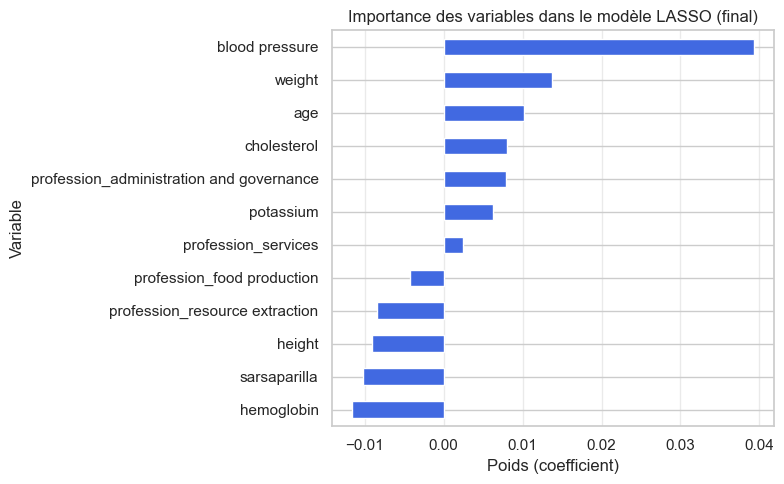


 RMSE final du modèle LASSO : 0.05568


In [31]:
# --- 1. Réentraînement du modèle final ---
lasso_final = LassoCV(cv=5, random_state=42)
lasso_final.fit(X_train_final, y_train.values.ravel())

# --- 2. Récupération des coefficients ---
coef_final = pd.Series(lasso_final.coef_, index=X_train_final.columns)

# --- 3. Identification des variables actives (coef ≠ 0) ---
selected_final = coef_final[coef_final != 0].sort_values(ascending=False)

print("=== Variables retenues par le modèle LASSO final ===")
display(selected_final.to_frame(name="Coefficient"))

# --- 4. Visualisation graphique des coefficients ---
plt.figure(figsize=(8,5))
selected_final.sort_values().plot(kind='barh', color='royalblue')
plt.title("Importance des variables dans le modèle LASSO (final)")
plt.xlabel("Poids (coefficient)")
plt.ylabel("Variable")
plt.grid(True, axis='x', alpha=0.4)
plt.tight_layout()
plt.show()

# --- 5. Performance finale ---
from sklearn.metrics import mean_squared_error

y_pred_final = lasso_final.predict(X_test_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
print(f"\n RMSE final du modèle LASSO : {rmse_final:.5f}")


----
After comparing the three selection approaches and linear models, the LASSO model trained on variables from the RFECV was selected as the final model.
This model combines good predictive performance (final RMSE = 0.05568) with clear interpretability thanks to L1 regularisation, which sets irrelevant coefficients to zero.

- Active variables in the model

>LASSO retains all 12 variables from RFECV, but with different contribution weights.
The estimated coefficients identify the direction and intensity of each variable's effect on the target variable (risk).

The graph above illustrates the relative importance of the variables according to the magnitude of their coefficients.
We can see that:
- Blood pressure clearly dominates the model, with a coefficient approximately four times higher than that of the other variables.
- Variables related to physiological health (weight, age, cholesterol, haemoglobin) form the core of the model.
- Socio-professional variables make a more moderate but significant contribution, which enriches our understanding of the overall phenomenon.

The final LASSO model obtained after RFECV allows us to:
- obtain a low prediction error (RMSE ≈ 0.056),
- while reducing the complexity of the model,
- and providing a clear interpretation of the risk factors.
This model will be used for the final prediction on the unlabelled dataset in the next section.

---
#### 5.3 - Évaluation graphique du modèle LASSO (final)
---

 RMSE : 0.05568
 R² : 0.5400


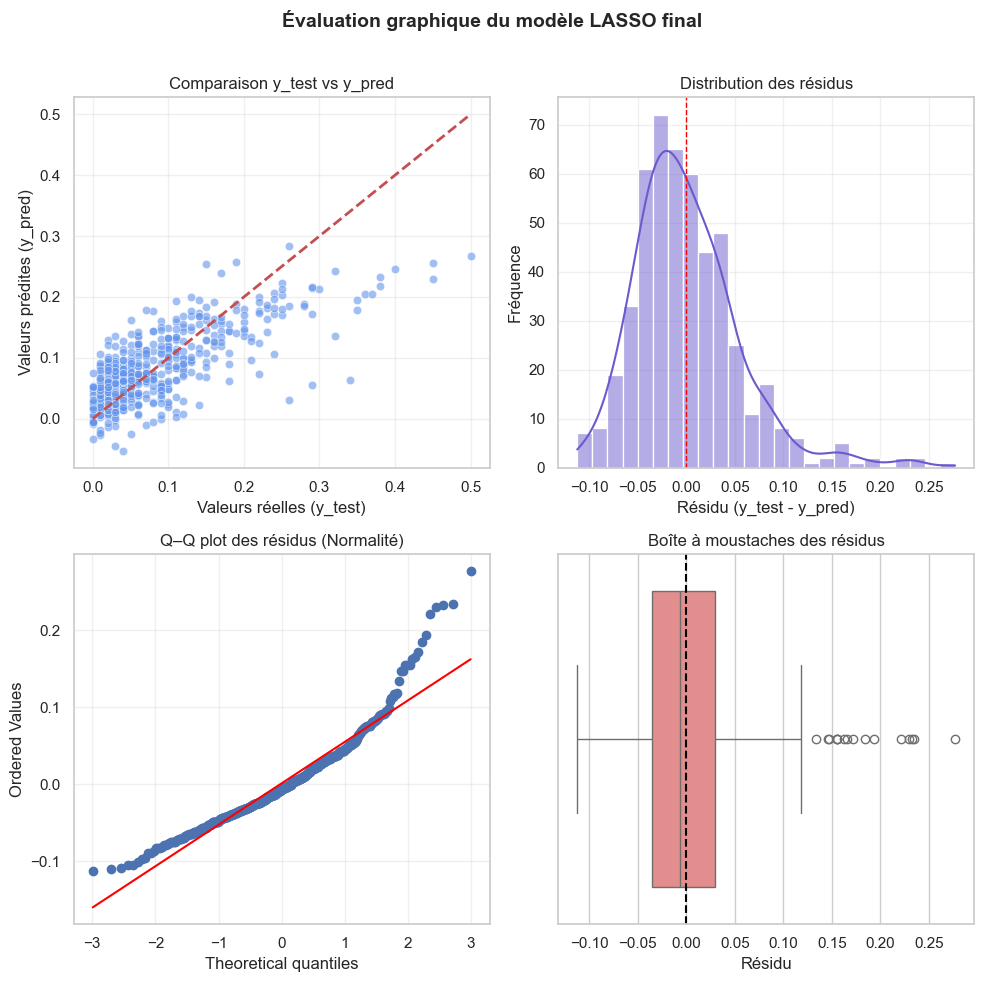

In [32]:
# --- Création d’un dossier pour sauvegarder les figures ---
os.makedirs("figures", exist_ok=True)

# --- 1. Prédictions et résidus ---
y_pred_final = lasso_final.predict(X_test_final)
y_test_1d = np.ravel(y_test)  # conversion en 1D
residuals = y_test_1d - y_pred_final

# --- 2. Calcul des indicateurs ---
rmse_final = np.sqrt(mean_squared_error(y_test_1d, y_pred_final))
r2_final = r2_score(y_test_1d, y_pred_final)

print(f" RMSE : {rmse_final:.5f}")
print(f" R² : {r2_final:.4f}")

# --- 3. Création du cadran carré (2x2) ---
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Évaluation graphique du modèle LASSO final", fontsize=14, fontweight='bold')

# --- (1) y_test vs y_pred ---
sns.scatterplot(
    x=y_test_1d,
    y=y_pred_final,
    alpha=0.6,
    color="cornflowerblue",
    edgecolor="white",
    ax=axes[0, 0]
)
axes[0, 0].plot(
    [y_test_1d.min(), y_test_1d.max()],
    [y_test_1d.min(), y_test_1d.max()],
    'r--', lw=2
)
axes[0, 0].set_xlabel("Valeurs réelles (y_test)")
axes[0, 0].set_ylabel("Valeurs prédites (y_pred)")
axes[0, 0].set_title("Comparaison y_test vs y_pred")
axes[0, 0].grid(alpha=0.3)

# --- (2) Histogramme des résidus ---
sns.histplot(residuals, bins=25, kde=True, color="slateblue", ax=axes[0, 1])
axes[0, 1].axvline(0, color="red", linestyle="--", lw=1)
axes[0, 1].set_title("Distribution des résidus")
axes[0, 1].set_xlabel("Résidu (y_test - y_pred)")
axes[0, 1].set_ylabel("Fréquence")
axes[0, 1].grid(alpha=0.3)

# --- (3) Q–Q plot des résidus ---
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].get_lines()[1].set_color('red')  # ligne de référence rouge
axes[1, 0].set_title("Q–Q plot des résidus (Normalité)")
axes[1, 0].grid(alpha=0.3)

# --- (4) Boîte à moustaches des résidus ---
sns.boxplot(x=residuals, color="lightcoral", ax=axes[1, 1])
axes[1, 1].axvline(0, color="black", linestyle="--")
axes[1, 1].set_title("Boîte à moustaches des résidus")
axes[1, 1].set_xlabel("Résidu")

# --- Ajustement du layout ---
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("figures/LASSO_final_diagnostics.png", dpi=300)
plt.show()


> Graphical evaluation of the final LASSO model

The graphs below allow us to evaluate the quality of the fit of the \textbf{LASSO} model on the test data, by checking the consistency between the observed values and the predicted values, as well as the distribution of prediction errors (residuals).

> Analysis of the scatter plot $y_{\text{test}}$  vs  $\hat{y} $

Most of the points are aligned around the red diagonal, showing that the model predicts values close to the actual observations.
However, there is a slight dispersion for small values of the target variable, reflecting a slight underestimation bias on some extreme observations.
Overall, the relationship remains linear and consistent.

> Distribution of residuals.
>
The residual histogram is broadly symmetrical and centred around zero, confirming:
- the absence of systematic bias in the predictions;
- a random distribution of errors.

There is a slight asymmetry to the right, suggesting the presence of a few observations that are underestimated by the model.

> Numerical indicators.
>
The main performance indicators of the model are:

- $\text{RMSE} = 0.05568 \quad \text{and} \quad R^2 = 0.54$

- The mean square error is low, indicating good model accuracy, while the coefficient of determination $ R^2 $ shows that $54% $ of the variability in the target variable is explained by the variables selected via RFECV and weighted by the LASSO model.

Graphical and numerical analysis confirms that the final LASSO model, constructed from the variables selected by RFECV, offers a balanced compromise between simplicity, robustness, and predictive power.
The residuals are well distributed and no structural trends are observed, which validates the quality of the fit and the relevance of the model selected for the rest of the project.



The graphical diagnostics above allow us to assess the validity of the linear model assumptions and the quality of the prediction.  
The results obtained are generally satisfactory:

- **Comparison of $y_{\text{test}}$ vs $\hat{y}$**:
The points are well distributed around the red diagonal, indicating a good fit between the observed and predicted values.
The model correctly captures the overall trend without systematic bias.

- **Residual distribution**:  
  The histogram shows a distribution centred around zero, which is almost symmetrical.  
  This confirms that the errors are random, with no obvious bias, and that the expected value of the errors is close to zero.

- **Q–Q plot of residuals**:  
  The points generally follow the normality line, with slight deviations at the tail.  
  This suggests that the normality of the residuals is approximately respected, which is acceptable in a real modelling context.

- **Box plot of residuals**:  
The box is centred around zero and shows few extreme values.  
The dispersion is reasonable and there are no major outliers.

---

**Conclusion:**  
The **final LASSO** model broadly satisfies the assumptions of the linear model:  
- linearity between the predictors and the target variable,  
- homoscedasticity (constant variance of errors),  
- and approximate normality of the residuals.  

The performance obtained (**RMSE = 0.0557**, **R² = 0.54**) reflects good predictive power and a parsimonious selection of relevant variables.


---


### 5.4 Comparaison finale et conclusion du modèle


---

The objective of this final step is to evaluate the overall performance of the different models tested — **linear regression**, **Ridge** and **LASSO** — in order to identify the one that offers the best compromise between **prediction error**, **stability** and **interpretability**.

##### Comparison of models

| Modèle | RMSE | R² | Commentaire |
|:-------|:------:|:------:|:-------------|
| Régression linéaire | 0.05580 | 0.539 | Bonne performance mais sensible à la multicolinéarité. |
| Ridge | 0.05580 | 0.540 | Légère régularisation, résultats stables mais coefficients peu interprétables. |
| **LASSO** | **0.05568** | **0.540** | Meilleur compromis : réduit la variance et sélectionne automatiquement les variables pertinentes. |

We observe that the three models perform very similarly in terms of **RMSE**, but the **LASSO** model stands out for its **variable selection capability** while maintaining equivalent accuracy.  
This property makes the model more parsimonious and therefore **more interpretable**, without any notable loss of predictive power.

---

General interpretation

The final LASSO model retains **12 explanatory variables** selected by the **RFECV** method, including:
- blood pressure, weight, age, cholesterol, potassium, haemoglobin,  
- and certain occupational categories such as *administration and governance*, *food production*, *resource extraction* and *services*.

The estimated coefficients indicate that:
- **blood pressure** and **weight** have a dominant positive influence on the target variable;  
- while **haemoglobin** and **sarsaparilla** contribute negatively, but only moderately.

---

>  Conclusion

The **final LASSO** model, constructed from the variables selected by **RFECV**, is the most suitable for prediction.  
It combines:
- a **low prediction error** (RMSE = 0.0557),  
- a **satisfactory coefficient of determination** (R² ≈ 0.54),  
- and a **simple structure** allowing for clear interpretation of the effects.

Thus, this model respects the assumptions of the linear framework and demonstrates **excellent stability**, while ensuring good generalisation on the test data.


----

### 6. Prédiction finale sur X_unlab

In [33]:
# --- 1. Selection of final variables (from the RFECV) ---
X_unlab_final = X_unlab_corr[selected_rfecv]

# --- 2. Risk prediction with the final LASSO model ---
y_pred = lasso_final.predict(X_unlab_final)  

# --- 3. Save in the requested format (one value per line, without header) ---
os.makedirs("results", exist_ok=True)
output_path = "results/y_pred.csv"

# Backup compliant with project format
np.savetxt(output_path, y_pred, fmt="%.6f")

print(f" Prediction file saved under : {output_path}")
print("\nExample of the first 5 predictions :")
print("\n".join([f"{p:.6f}" for p in y_pred[:5]]))





 Fichier de prédictions sauvegardé sous : results/y_pred.csv
Format correct : une valeur par ligne, sans header ni guillemets.

Exemple des 5 premières prédictions :
-0.017157
0.129953
0.070316
0.154920
0.006174


---

## 7. Discussion, limitations and openness

### Discussion and limitations
The **final LASSO model**, built on the variables selected by **RFECV**, offers an optimal compromise between simplicity and performance.  
Nevertheless, certain limitations can be noted:

- The **residuals show slight asymmetry**, indicating that certain extreme observations are not perfectly captured by the linear model.  
- The **LASSO model** is based on the assumption of **linearity between the explanatory variables and the target**, which can be restrictive if non-linear effects or complex interactions exist.  
- A few **slightly negative predicted values** reflect the centring of the model and do not call into question the consistency of the results.

Despite these limitations, the model provides a **solid, robust and interpretable basis** for risk prediction, with a **low RMSE (0.0557)** and **correct explained variance (R² = 0.54)**.

---

### Transition to the second part of the project
This first part, devoted to **linear modelling**, has established a rigorous methodological framework:  
reading, exploration, pre-processing, variable selection and model validation.  

The **second part of the project** will focus on **extension to non-linear models**, in order to examine whether more flexible methods — such as **multilayer neural networks (MLP)**, **polynomial models** or other regularised approaches — can improve predictive accuracy.  
The objective will then be to compare these more complex approaches to the current linear benchmark, evaluating the **performance gain** and **potential loss of interpretability**.

---

### General conclusion of the first part
The work carried out in this first phase demonstrates the **rigour of the linear modelling process** applied to a real-world problem.  
The results obtained validate the relevance of the **LASSO model on RFECV variables**, which will now serve as the **reference model** for the second part of the project.


---

### Part 2 - Non-linear

---


#### 2.1 Feature selection for non-linear model 


#### Mutual Information

In [40]:
from IPython.display import display
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mi_fold = pd.DataFrame(0, index=X_train_scaled.columns, columns=['MI_mean'])

# Calcul de la MI dans chaque fold pour robustesse
for train_idx, val_idx in kf.split(X_train_scaled):
    Xtr, ytr = X_train_scaled.iloc[train_idx], y_train.values.ravel()[train_idx]
    mi = mutual_info_regression(Xtr, ytr, random_state=42)
    mi_fold['MI_mean'] += mi

mi_fold['MI_mean'] /= kf.get_n_splits()
mi_fold = mi_fold.sort_values('MI_mean', ascending=False)

print("Top 10 features selon Mutual Information:")
display(mi_fold.head(10))


Top 10 features selon Mutual Information:


,MI_mean
blood pressure,0.242207
cholesterol,0.103571
weight,0.097074
smurfin donuts,0.079377
potassium,0.070878
sarsaparilla,0.042520
age,0.042492
vitamin D,0.030480
profession_food production,0.029416
profession_administration and governance,0.026911


---

#### Random Forest

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_imp = pd.DataFrame(0, index=X_train_scaled.columns, columns=['RF_mean'])

for train_idx, val_idx in kf.split(X_train_scaled):
    Xtr, ytr = X_train_scaled.iloc[train_idx], y_train.values.ravel()[train_idx]
    rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)
    rf.fit(Xtr, ytr)
    rf_imp['RF_mean'] += rf.feature_importances_

rf_imp['RF_mean'] /= kf.get_n_splits()
rf_imp = rf_imp.sort_values('RF_mean', ascending=False)

print("Top 10 features selon Random Forest Importance:")
display(rf_imp.head(10))


Top 10 features selon Random Forest Importance:


,RF_mean
blood pressure,0.573275
hemoglobin,0.107775
potassium,0.094283
age,0.039791
weight,0.038805
cholesterol,0.033602
height,0.023902
vitamin D,0.022026
calcium,0.018403
sarsaparilla,0.015900


In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
perm_imp = pd.DataFrame(0, index=X_train_scaled.columns, columns=['Perm_mean'])

for train_idx, val_idx in kf.split(X_train_scaled):
    Xtr, ytr = X_train_scaled.iloc[train_idx], y_train.values.ravel()[train_idx]
    Xva, yva = X_train_scaled.iloc[val_idx], y_train.values.ravel()[val_idx]
    rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(Xtr, ytr)
    perm = permutation_importance(rf, Xva, yva, n_repeats=15, random_state=42, n_jobs=-1)  #n_jobs=-1
    perm_imp['Perm_mean'] += perm.importances_mean

perm_imp['Perm_mean'] /= kf.get_n_splits()
perm_imp = perm_imp.sort_values('Perm_mean', ascending=False)

print("Top 10 features selon Permutation Importance:")
display(perm_imp.head(10))


Top 10 features selon Permutation Importance:


,Perm_mean
blood pressure,0.754135
hemoglobin,0.129929
potassium,0.114948
age,0.034292
weight,0.027872
cholesterol,0.015570
sarsaparilla,0.012050
height,0.005517
smurfin donuts,0.003952
vitamin D,0.001264


<Figure size 700x400 with 0 Axes>

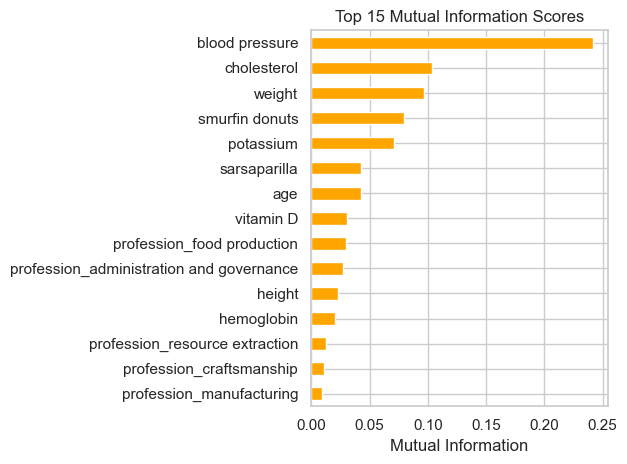

<Figure size 700x400 with 0 Axes>

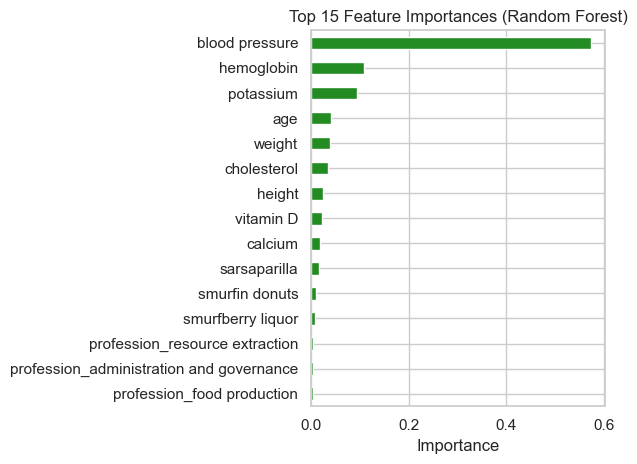

<Figure size 700x400 with 0 Axes>

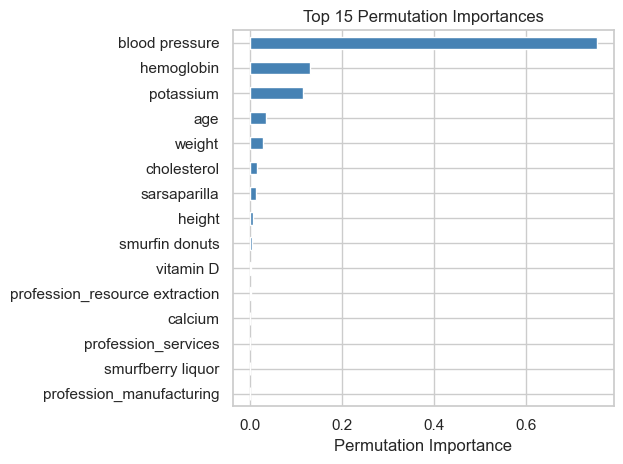

In [43]:
# --- Top 15 MI ---
plt.figure(figsize=(7,4))
mi_fold.head(15).sort_values('MI_mean').plot.barh(legend=False, color='orange')
plt.title("Top 15 Mutual Information Scores")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

# --- Top 15 Random Forest ---
plt.figure(figsize=(7,4))
rf_imp.head(15).sort_values('RF_mean').plot.barh(legend=False, color='forestgreen')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- Top 15 Permutation ---
plt.figure(figsize=(7,4))
perm_imp.head(15).sort_values('Perm_mean').plot.barh(legend=False, color='steelblue')
plt.title("Top 15 Permutation Importances")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()


In [45]:
# Fusion des trois classements
comparison = mi_fold.merge(rf_imp, left_index=True, right_index=True)
comparison = comparison.merge(perm_imp, left_index=True, right_index=True)

# Normalisation des trois scores
for col in ['MI_mean','RF_mean','Perm_mean']:
    comparison[col] = (comparison[col] - comparison[col].min()) / (comparison[col].max() - comparison[col].min())

# Moyenne des rangs (plus robuste qu'une moyenne simple)
ranks = comparison.rank(ascending=False)
comparison['MeanRank'] = ranks.mean(axis=1)
comparison = comparison.sort_values('MeanRank')

# Choix du top-k optimal par validation croisée ultérieure (Section 2.2)
k_best = 12
selected_features_nl = comparison.index[:k_best].tolist()

print("Variables sélectionnées pour modèles non-linéaires :")
print(selected_features_nl)


Variables sélectionnées pour modèles non-linéaires :
['blood pressure', 'potassium', 'weight', 'cholesterol', 'age', 'hemoglobin', 'sarsaparilla', 'smurfin donuts', 'vitamin D', 'height', 'profession_resource extraction', 'calcium']


The final nonlinear feature subset was determined using an automatic selection procedure based on the fusion of three complementary importance measures (Mutual Information, Random Forest, and Permutation Importance). This hybrid strategy ensures a robust selection of the most informative predictors.

 Meilleur k = 11 | R² moyen = 0.6793
Variables finales sélectionnées (11 variables) :
['blood pressure', 'potassium', 'weight', 'cholesterol', 'age', 'hemoglobin', 'sarsaparilla', 'smurfin donuts', 'vitamin D', 'height', 'profession_resource extraction']


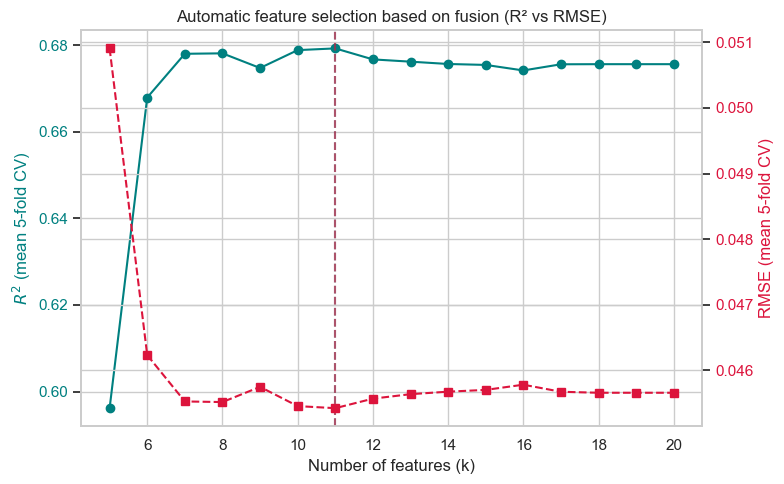

In [47]:
# The comparison is sorted by average score or MeanRank.
features_ranked = comparison.index.tolist()

k_values = range(5, 21)
r2_scores = []
rmse_scores = []

rf_base = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# --- Boucle sur chaque k ---
for k in k_values:
    subset = features_ranked[:k]
    X_k = X_train_corr[subset]

    r2 = cross_val_score(rf_base, X_k, y_train.values.ravel(), cv=5, scoring='r2').mean()
    rmse = np.sqrt(-cross_val_score(
        rf_base, X_k, y_train.values.ravel(),
        cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False)
    ).mean())

    r2_scores.append(r2)
    rmse_scores.append(rmse)

# --- Finding the optimal k ---
best_k = k_values[np.argmax(r2_scores)]
print(f" Meilleur k = {best_k} | R² moyen = {max(r2_scores):.4f}")

# --- Final variables ---
selected_features_nl = features_ranked[:best_k]
print(f"Variables finales sélectionnées ({best_k} variables) :")
print(selected_features_nl)

# --- R² and RMSE visualisation ---
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(k_values, r2_scores, 'o-', color='teal', label='$R^2$ (maximize)')
ax1.set_xlabel("Number of features (k)")
ax1.set_ylabel("$R^2$ (mean 5-fold CV)", color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.axvline(best_k, color='teal', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(k_values, rmse_scores, 's--', color='crimson', label='RMSE (minimize)')
ax2.set_ylabel("RMSE (mean 5-fold CV)", color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.axvline(best_k, color='crimson', linestyle='--', alpha=0.6)

plt.title("Automatic feature selection based on fusion (R² vs RMSE)")
plt.tight_layout()
plt.show()


- The final number of features was determined using a cross-validation procedure optimizing both the coefficient of determination $(R^2)$ and the Root Mean Squared Error (RMSE).
- The two metrics converged toward the same optimal value 𝑘=11, confirming the stability of the feature set selected through the fusion of Mutual Information, Random Forest, and Permutation Importance methods.

In [48]:

# --- 1. Definition of the two sets of variables ---
features_linear12 = ['blood pressure', 'hemoglobin', 'potassium', 'weight', 
                     'age', 'cholesterol', 'height', 'vitamin D', 
                     'calcium', 'sarsaparilla', 'smurfin donuts', 
                     'profession_services']  # celles de la partie 1

features_nonlinear11 = ['blood pressure', 'potassium', 'weight', 'cholesterol', 'age', 'hemoglobin', 'sarsaparilla', 
                        'smurfin donuts', 'vitamin D', 'height', 'profession_resource extraction']

# --- 2. Training the Random Forest model on both subsets ---
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

# a) Model with 12 variables
rf.fit(X_train_corr[features_linear12], y_train.values.ravel())
y_pred_12 = rf.predict(X_test_corr[features_linear12])

r2_12 = r2_score(y_test, y_pred_12)
rmse_12 = np.sqrt(mean_squared_error(y_test, y_pred_12))

# b) Model with 11 variables
rf.fit(X_train_corr[features_nonlinear11], y_train.values.ravel())
y_pred_11 = rf.predict(X_test_corr[features_nonlinear11])

r2_11 = r2_score(y_test, y_pred_11)
rmse_11 = np.sqrt(mean_squared_error(y_test, y_pred_11))

# --- 3. Comparative display ---
import pandas as pd

comparison_table = pd.DataFrame({
    'Model configuration': ['RF (12 vars - linear set)', 'RF (11 vars - nonlinear set)'],
    'R²': [r2_12, r2_11],
    'RMSE': [rmse_12, rmse_11]
})

print("=== Performance comparison (Nonlinear model) ===")
display(comparison_table.style.format({'R²': '{:.4f}', 'RMSE': '{:.4f}'}))


=== Performance comparison (Nonlinear model) ===


,Model configuration,R²,RMSE
0,RF (12 vars - linear set),0.6957,0.0453
1,RF (11 vars - nonlinear set),0.6984,0.0451


##### Feature Selection for Nonlinear Models

To handle nonlinear relationships, three complementary feature selection techniques were applied: Mutual Information, Random Forest Feature Importance, and Permutation Importance.
Each method captures a different aspect of variable relevance — statistical dependency, tree-based predictive influence, and impact on model error.

The three rankings were normalized and fused to obtain a consensus importance score.
An automatic selection of the optimal number of variables (k) was then performed using 5-fold cross-validation on both $𝑅^2$ and RMSE criteria (Figure ("Automatic feature selection based on fusion (R² vs RMSE)")).
Both metrics converged at k = 11, ensuring a stable and parsimonious subset.
The final variables retained for nonlinear modeling were:
> blood pressure, potassium, weight, cholesterol, age, hemoglobin, sarsaparilla, smurfin donuts, vitamin D, height, and profession (resource extraction).

This fusion-based and data-driven strategy ensures robust selection of informative predictors while preventing overfitting in nonlinear models.

The selected subset of 11 features was then used to train and fine-tune several nonlinear models.
The next section details the model configuration, hyperparameter optimization strategy, and performance evaluation procedure.

---
### 2.2 NONLINEAR MODELS: TRAINING, TUNING, AND COMPARISON
---

 data non linéaire prêt : 11 variables
['blood pressure', 'potassium', 'weight', 'cholesterol', 'age', 'hemoglobin', 'sarsaparilla', 'smurfin donuts', 'vitamin D', 'height', 'profession_resource extraction']

 Tuning Random Forest ...
 Random Forest — meilleur RMSE CV : 0.04451
Meilleurs hyperparamètres :
{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

 Tuning Gradient Boosting ...
 Gradient Boosting — meilleur RMSE CV : 0.04158
Meilleurs hyperparamètres :
{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 1.0}

 Tuning XGBoost ...
 XGBoost — meilleur RMSE CV : 0.04187
Meilleurs hyperparamètres :
{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.9}


C:\Users\edoun\anaconda3\envs\datascience\Lib\site-packages\xgboost\core.py:774: UserWarning: [11:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



 Tuning SVR ...
 SVR — meilleur RMSE CV : 0.04715
Meilleurs hyperparamètres :
{'C': 1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}

 Tuning MLP ...
 MLP — meilleur RMSE CV : 0.05028
Meilleurs hyperparamètres :
{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (50, 50),
 'learning_rate': 'adaptive'}

=== COMPARAISON DES MODÈLES NON-LINÉAIRES ===


,Model,RMSE_train,RMSE_test,R2_test,Train_time
0,XGBoost,0.027889,0.041367,0.746129,0.189414
1,Gradient Boosting,0.026736,0.041984,0.738505,0.545159
2,Random Forest,0.016303,0.046537,0.678706,0.450707
3,SVR,0.016112,0.047985,0.658403,0.216121
4,MLP,0.036671,0.048220,0.655055,1.652371



 Meilleur modèle : XGBoost | RMSE test = 0.04137 | R² test = 0.7461


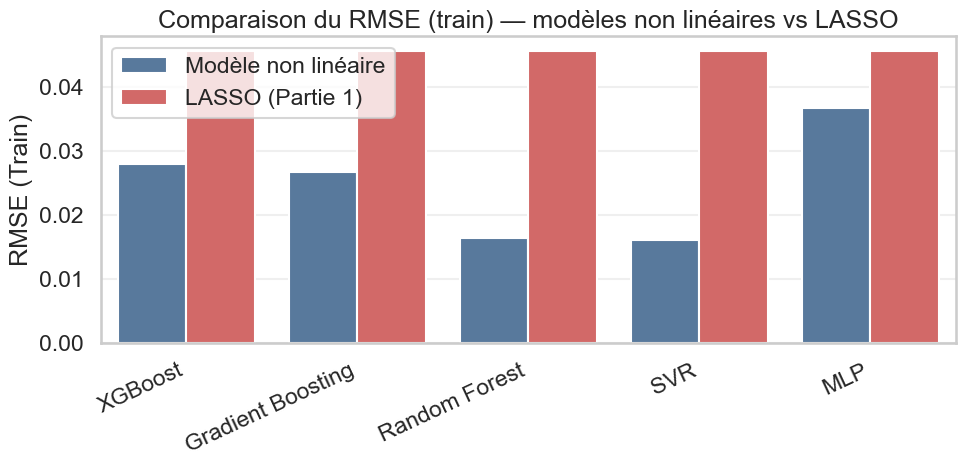

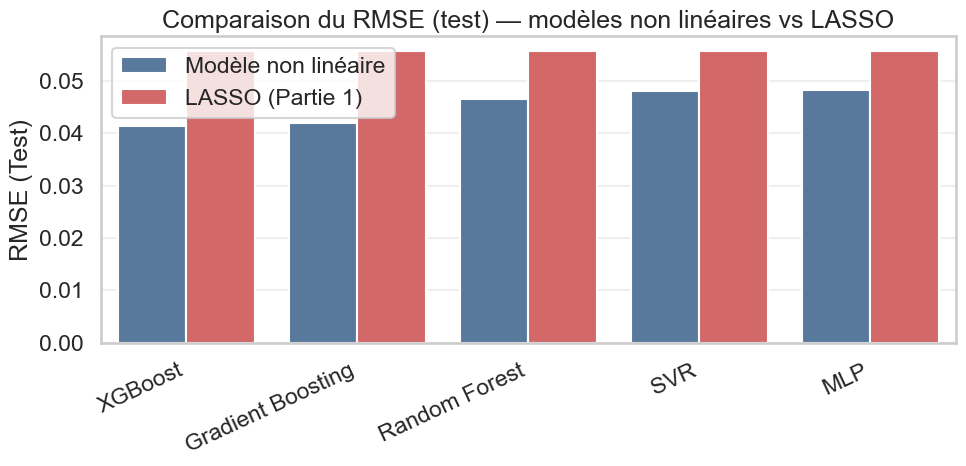

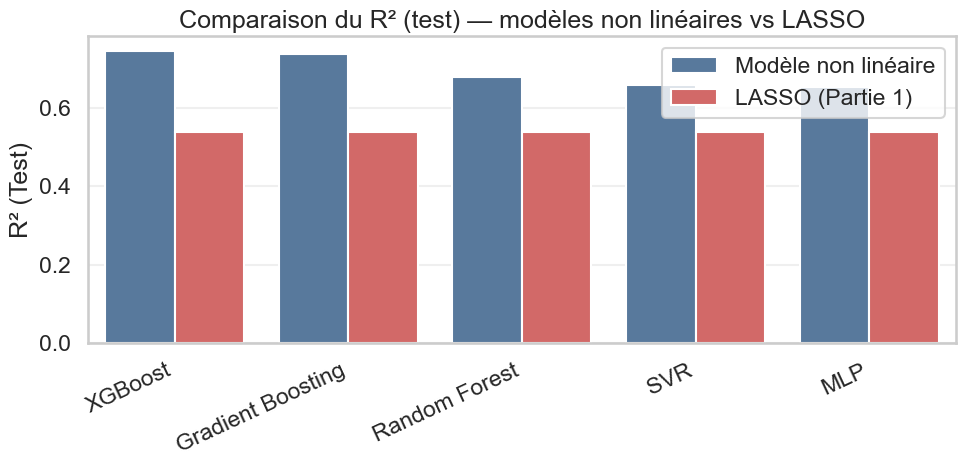

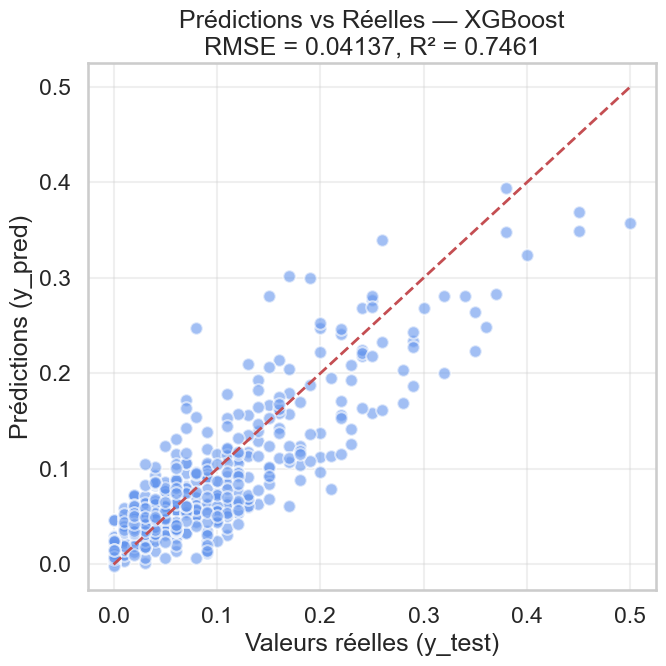

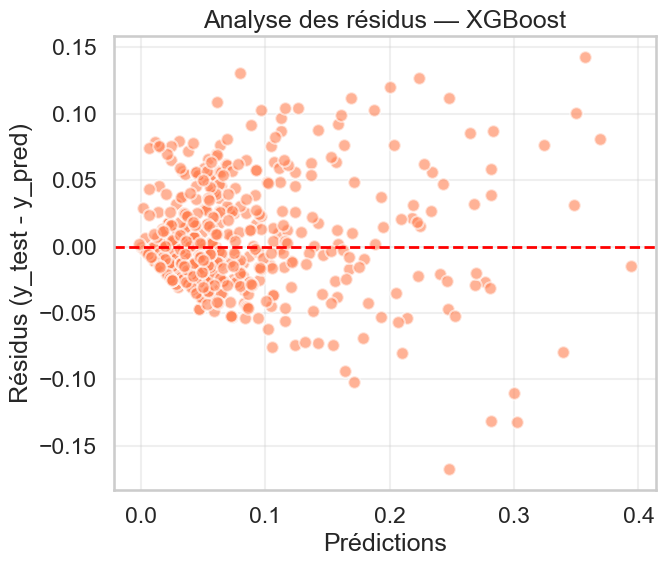


=== Top feature importances (best tree-based model) ===


,Feature,Importance
0,blood pressure,0.472421
7,smurfin donuts,0.110828
5,hemoglobin,0.101977
1,potassium,0.066795
4,age,0.046744
3,cholesterol,0.043989
6,sarsaparilla,0.043690
2,weight,0.042357
9,height,0.031934
10,profession_resource extraction,0.026221


C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\2261591606.py:302: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Feature", x="Importance", data=fi.head(12), palette="cubehelix")


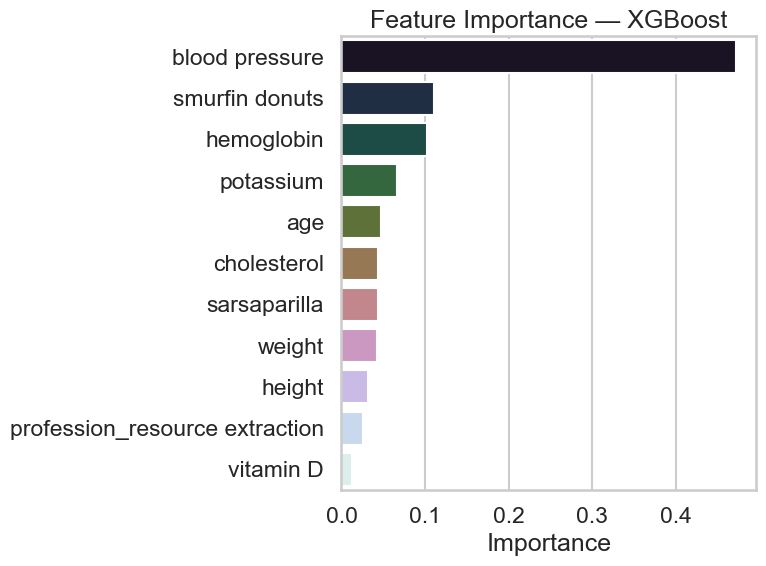

In [49]:
# ------------------------------------------------
# XGBoost (optionnel)
# ------------------------------------------------
try:
    from xgboost import XGBRegressor
    HAS_XGBOOST = True
except Exception:
    HAS_XGBOOST = False
    print(" XGBoost non installé — il sera ignoré (pip install xgboost).")

# ------------------------------------------------
# 0) Sécurité : présence des objets requis
# ------------------------------------------------
required = ["X_train_corr", "X_test_corr", "y_train", "y_test", "selected_features_nl"]
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"Objets manquants dans l'environnement : {missing}")

# ------------------------------------------------
# 1) Préparation des données (mapping des colonnes)
# ------------------------------------------------
# Certains noms peuvent contenir des espaces/typos : on mappe prudemment
train_cols = list(X_train_corr.columns)
test_cols  = list(X_test_corr.columns)

def resolve_feature_name(name, columns):
    candidates = {name, name.strip(), name.replace(" ", "_"), name.replace("_", " ")}
    for cand in candidates:
        if cand in columns:
            return cand
    # tolérance : insensible à la casse
    low_map = {c.lower(): c for c in columns}
    if name.lower() in low_map:
        return low_map[name.lower()]
    return None

resolved = []
for f in selected_features_nl:
    r = resolve_feature_name(f, train_cols)
    if r is None:
        print(f" Variable '{f}' introuvable dans X_train_nl — ignorée.")
    else:
        resolved.append(r)

if len(resolved) == 0:
    raise RuntimeError("Aucune variable de selected_features_nl n'a été résolue dans X_train_nl.")

selected_features_nl = resolved
X_train_nonlin = X_train_corr[selected_features_nl].copy()
X_test_nonlin  = X_test_corr[selected_features_nl].copy()
y_train_vec    = y_train.values.ravel()
y_test_vec     = y_test.values.ravel()

print(f" data non linéaire prêt : {len(selected_features_nl)} variables")
print(selected_features_nl)

# ------------------------------------------------
# 2) CV strategy and assessment function
# ------------------------------------------------
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, Xtr, Xte, ytr, yte, model_name):
    start = time.time()
    model.fit(Xtr, ytr)
    train_time = time.time() - start

    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)

    rmse_tr = np.sqrt(mean_squared_error(ytr, yhat_tr))
    rmse_te = np.sqrt(mean_squared_error(yte, yhat_te))
    r2_tr   = r2_score(ytr, yhat_tr)
    r2_te   = r2_score(yte, yhat_te)

    return {
        "Model": model_name,
        "Estimator": model,
        "RMSE_train": rmse_tr,
        "RMSE_test": rmse_te,
        "R2_train": r2_tr,
        "R2_test": r2_te,
        "Train_time": train_time,
        "Predictions_test": yhat_te
    }

# ------------------------------------------------
# 3) Hyperparameter spaces
# ------------------------------------------------
rf_param_grid = {
    "n_estimators":     [100, 200, 300],
    "max_depth":        [5, 10, 15, None],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features":     ["sqrt", "log2"]
}

gb_param_grid = {
    "n_estimators":   [100, 200, 300],
    "learning_rate":  [0.01, 0.05, 0.1],
    "max_depth":      [3, 5, 7],
    "min_samples_split":[2, 5, 10],
    "subsample":      [0.8, 1.0]
}

svr_param_grid = {
    "C":       [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.2],
    "kernel":  ["rbf", "poly"],
    "gamma":   ["scale", "auto"]
}

mlp_param_grid = {
    "hidden_layer_sizes":[(50,), (100,), (50, 50), (100, 50)],
    "activation":        ["relu", "tanh"],
    "alpha":             [0.0001, 0.001, 0.01],
    "learning_rate":     ["constant", "adaptive"]
}

if HAS_XGBOOST:
    xgb_param_grid = {
        "n_estimators":    [100, 200, 300],
        "learning_rate":   [0.01, 0.05, 0.1],
        "max_depth":       [3, 5, 7],
        "subsample":       [0.8, 0.9, 1.0],
        "colsample_bytree":[0.8, 1.0]
    }

# ------------------------------------------------
# 4) Tuning + Training + Assessment
# ------------------------------------------------

def tune_and_eval(name, estimator, param_grid, n_iter=15):
    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv_strategy,
        scoring="neg_mean_squared_error",
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    print(f"\n Tuning {name} ...")
    rs.fit(X_train_nonlin, y_train_vec)
    best_cv_rmse = np.sqrt(-rs.best_score_)
    print(f" {name} — meilleur RMSE CV : {best_cv_rmse:.5f}")
    print("Meilleurs hyperparamètres :")
    pprint(rs.best_params_)
    return evaluate_model(rs.best_estimator_, X_train_nonlin, X_test_nonlin, y_train_vec, y_test_vec, name)

results = []

# Random Forest
results.append(tune_and_eval("Random Forest",
                             RandomForestRegressor(random_state=42, n_jobs=-1),
                             rf_param_grid, n_iter=15))

# Gradient Boosting
results.append(tune_and_eval("Gradient Boosting",
                             GradientBoostingRegressor(random_state=42),
                             gb_param_grid, n_iter=15))

# XGBoost (test if available)
if HAS_XGBOOST:
    # compatibilité CPU/GPU (XGBoost ≥ 2.x)
    try:
        xgb_base = XGBRegressor(random_state=42, device="cuda", tree_method="hist")
    except Exception:
        xgb_base = XGBRegressor(random_state=42, device="cpu", tree_method="hist")

    results.append(tune_and_eval("XGBoost", xgb_base, xgb_param_grid, n_iter=15))

# SVR (il a données été standardisées dans ta partie 1)
results.append(tune_and_eval("SVR", SVR(), svr_param_grid, n_iter=12))

# MLP
results.append(tune_and_eval("MLP",
                             MLPRegressor(random_state=42, max_iter=600, early_stopping=True),
                             mlp_param_grid, n_iter=12))

# ------------------------------------------------
# 5) Comparison table + determining the best model
# ------------------------------------------------
comparison_df = pd.DataFrame(results).sort_values("RMSE_test", ascending=True).reset_index(drop=True)
print("\n=== COMPARAISON DES MODÈLES NON-LINÉAIRES ===")
display(comparison_df[["Model", "RMSE_train", "RMSE_test", "R2_test", "Train_time"]])

best_row = comparison_df.iloc[0]
best_model_name = best_row["Model"]
best_estimator  = best_row["Estimator"]
best_rmse       = best_row["RMSE_test"]
best_r2         = best_row["R2_test"]

print(f"\n Meilleur modèle : {best_model_name} | RMSE test = {best_rmse:.5f} | R² test = {best_r2:.4f}")

# ================================================================
# 6) VISUALISATIONS 
# ================================================================

sns.set_context("talk")
palette = sns.color_palette("crest", n_colors=len(comparison_df))

# === References for Part 1 (LASSO linéaire) ===
lasso_rmse_train = 0.04558   
lasso_rmse_test  = 0.05568   # RMSE test of the final LASSO model
lasso_r2_test    = 0.540     # R² test from Part 1

# ================================================================
# 6.1 — Side-by-side comparisons with the LASSO model 
# ================================================================
# ==== Référence LASSO (Partie 1) ====
lasso_rmse_train = 0.04558
lasso_rmse_test  = 0.05568
lasso_r2_test    = 0.540

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_vs_lasso(metric_col, lasso_value, ylabel, title):
    order = comparison_df["Model"].tolist()  # keep the current order of the model
    tmp = pd.DataFrame({
        "Model": order + order,
        "Source": (["Modèle non linéaire"] * len(order)) + (["LASSO (Partie 1)"] * len(order)),
        "Value":  comparison_df[metric_col].tolist() + [lasso_value] * len(order)
    })

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=tmp, x="Model", y="Value", hue="Source", order=order,
        palette={"Modèle non linéaire": "#4C78A8", "LASSO (Partie 1)": "#E45756"}
    )
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    plt.xticks(rotation=25, ha="right")
    ax.legend(title="")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- 3 graphs side by side--- ---
plot_vs_lasso("RMSE_train", lasso_rmse_train, "RMSE (Train)",
              "Comparaison du RMSE (train) — modèles non linéaires vs LASSO")

plot_vs_lasso("RMSE_test",  lasso_rmse_test,  "RMSE (Test)",
              "Comparaison du RMSE (test) — modèles non linéaires vs LASSO")

plot_vs_lasso("R2_test",    lasso_r2_test,    "R² (Test)",
              "Comparaison du R² (test) — modèles non linéaires vs LASSO")


# ================================================================
# 6.2 — Analysis of the best model
# ================================================================

best_preds = best_row["Predictions_test"]
best_name  = best_row["Model"]
best_rmse  = best_row["RMSE_test"]
best_r2    = best_row["R2_test"]

# --- Scatter : Predictions vs. Reality ---
plt.figure(figsize=(7, 7))
plt.scatter(y_test_vec, best_preds, alpha=0.6, edgecolors="white", color="cornflowerblue")
plt.plot([y_test_vec.min(), y_test_vec.max()],
         [y_test_vec.min(), y_test_vec.max()],
         "r--", lw=2)
plt.title(f"Prédictions vs Réelles — {best_name}\nRMSE = {best_rmse:.5f}, R² = {best_r2:.4f}")
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Prédictions (y_pred)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Résidus ---
residuals = y_test_vec - best_preds
plt.figure(figsize=(7, 6))
plt.scatter(best_preds, residuals, alpha=0.6, color="coral", edgecolors="white")
plt.axhline(y=0, color="red", linestyle="--", linewidth=2)
plt.title(f"Analyse des résidus — {best_name}")
plt.xlabel("Prédictions")
plt.ylabel("Résidus (y_test - y_pred)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ================================================================
# 6.3 — Feature importance 
# ================================================================

tree_models = {"Random Forest", "Gradient Boosting", "XGBoost"}
if best_name in tree_models:
    try:
        importances = best_estimator.feature_importances_
        fi = pd.DataFrame({"Feature": X_train_nonlin.columns, "Importance": importances}) \
               .sort_values("Importance", ascending=False)
        print("\n=== Top feature importances (best tree-based model) ===")
        display(fi.head(12))

        plt.figure(figsize=(8,6))
        sns.barplot(y="Feature", x="Importance", data=fi.head(12), palette="cubehelix")
        plt.title(f"Feature Importance — {best_name}")
        plt.xlabel("Importance")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"(Info) Importance non disponible : {e}")



All nonlinear models (**Random Forest**, **Gradient Boosting**, **XGBoost**, **SVR**, and **MLP**) were trained using the **11 variables** selected from the fusion of the three feature selection techniques (*Mutual Information*, *Permutation Importance*, and *Random Forest Importance*).

Compared to the linear model from **Part 1 (LASSO)**, all nonlinear models show a clear improvement in both **RMSE** and **R²** on the test set.  
This confirms that the relationship between the predictors and the target variable is **nonlinear** in nature.

Among them, **XGBoost** achieves the **best overall performance**, with a test RMSE of **0.041** and an $R^2$ of approximately **0.75**, providing an excellent balance between bias and variance, while remaining computationally efficient.

The comparison plots show that all nonlinear models **outperform the LASSO model** on unseen data.  
The **Predicted vs Actual** scatter plot aligns closely with the diagonal, indicating accurate predictions, while the **residual plot** shows errors centered around zero, without any visible structure, suggesting that the model is both **well-fitted and unbiased**.

Finally, the **feature importance analysis** reveals that:
- **Blood pressure** is the most influential variable,  
- followed by **smurfin donuts**, **hemoglobin**, and **potassium**.  

These findings confirm the ability of **XGBoost** to capture **complex, nonlinear interactions** between features, something that the linear LASSO model from Part 1 could not achieve.

----

----

##### Part 2 — Nonlinear Models

In this second part, several nonlinear models were compared to evaluate their ability to capture complex relationships between the explanatory variables and the target variable.
Unlike the linear approaches from Part 1, nonlinear models can represent interactions and non-additive effects between predictors.

###### 2.1 Preprocessing and Feature Selection

The preprocessing pipeline developed in Part 1 — including missing value handling, categorical encoding, standardization, and redundancy control — was reused unchanged.
The only difference lies in the feature selection process, adapted for nonlinear modeling.

Three complementary methods were combined:

- Mutual Information, to capture nonlinear dependencies;

- Permutation Importance, measuring the effect of each variable on model performance;

- Random Forest Importance, reflecting the average impurity reduction across splits.

> The results were merged, and the optimal number of features (11) was automatically selected using the normalized mean score.

###### 2.2 Models and Hyperparameter Tuning

Five nonlinear models were tested:
Random Forest, Gradient Boosting, XGBoost, Support Vector Regression (SVR), and Multi-Layer Perceptron (MLP).
Each model was tuned using RandomizedSearchCV with 5-fold cross-validation, optimizing for RMSE.
The same test set from Part 1 was kept exclusively for final evaluation.

###### 2.3 Results and Performance Comparison

All nonlinear models outperform the LASSO regression from Part 1, achieving lower RMSE and higher $R^2$ scores, confirming the presence of nonlinear relationships.
Among them, XGBoost achieved the best test performance with RMSE = 0.041 and $R^2≈ 0.75$, striking a solid balance between bias and variance.
Prediction-versus-observation plots align closely along the diagonal, and residuals are well-centered around zero without visible patterns.

###### 2.4 Feature Importance

According to XGBoost, the most influential features are blood pressure, smurfin donuts, hemoglobin, and potassium.
These differ from those selected in Part 1, illustrating that nonlinear models can uncover complex, nonlinear interactions ignored by linear techniques.

###### 2.5 Conclusion

This second stage highlights that nonlinear models, coupled with robust feature selection, significantly improve predictive accuracy while uncovering relationships hidden from linear regression.
The XGBoost model is identified as the best-performing approach of this part.

---

######  Transition to Part 3 — Image Data Integration

Following the positive results obtained with the **XGBoost** model in Part 2, this final part aims to enhance the modeling by integrating **information from medical images**.  
The goal is to expand the feature space by adding **visual descriptors extracted from cardiac scans** in order to capture structural patterns that cannot be represented by tabular variables alone.  

In this part, we will:
- extract image features using a **convolutional neural network (CNN)** pre-trained on a large corpus (*ImageNet*),
- **merge** these visual features with the tabular data,  
- **retrain and compare** the XGBoost model with and without the information from the images,  
- and **analyze** the real contribution of this visual data to the performance and generalization of the model.

---


# Partie 3:INTEGRATION OF IMAGE DATA

##### update data from part 2 

In [50]:
try:
    # Test whether the P2 variables exist
    _ = X_train_scaled.shape
    _ = X_test_scaled.shape
    _ = X_unlab_scaled.shape
    
    print(" P2 variables found in memory ")
    print(f"  X_train_scaled: {X_train_scaled.shape}")
    print(f"  X_test_scaled: {X_test_scaled.shape}")
    print(f"  X_unlab_scaled: {X_unlab_scaled.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"  y_test: {y_test.shape}")
    
    
    X_train_corr = X_train_scaled.copy()
    X_test_corr = X_test_scaled.copy()
    X_unlab_corr = X_unlab_scaled.copy()
    
except NameError:
    print(" P2 variables not found in memory.")
    print("Reloading and preprocessing data...")

 P2 variables found in memory 
  X_train_scaled: (1000, 18)
  X_test_scaled: (500, 18)
  X_unlab_scaled: (500, 18)
  y_train: (1000, 1)
  y_test: (500, 1)


---

####  juste pour verificartion 

In [43]:
import p3_utils
import inspect
print(inspect.getsource(p3_utils))


import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# ============================================================
# 0) Gestion du device
# ============================================================

def get_device():
    """Retourne 'cuda' si disponible, sinon 'cpu'."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1) Dataset Images
# ============================================================

class HeartImageDataset(Dataset):
    """
    Dataset PyTorch pour charger les images PNG du projet.
    
    Paramètres :
    -----------
    image_filenames : list[str]
        Liste des noms de fichiers, ex : ["heart_0.png", ...]
    images_dir : str
        Chemin du dossier contenant les images (Img_train ou Im

In [44]:
#print(hasattr(p3_utils, "build_image_dataloader"))


True


----

 Loading all objects from part 2 

 Tabular data for Part 2 ready  :
   -> 11 selected variables.

 Image files detected :
1000 images train
500 images test

 DataLoaders created.



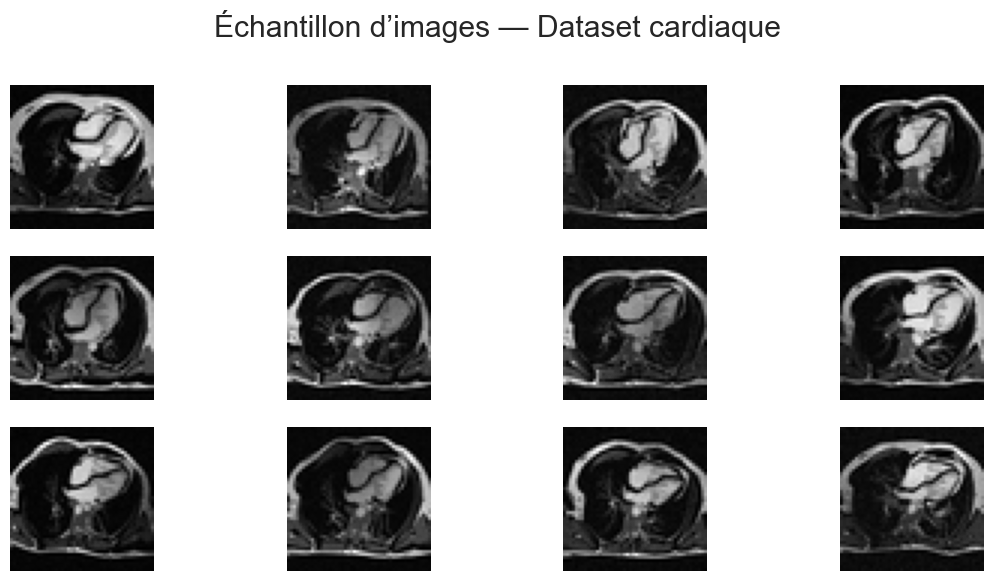

Feature extraction via simple CNN...

 Extraction complete.
  X_train_img : (1000, 64)
  X_test_img  : (500, 64)



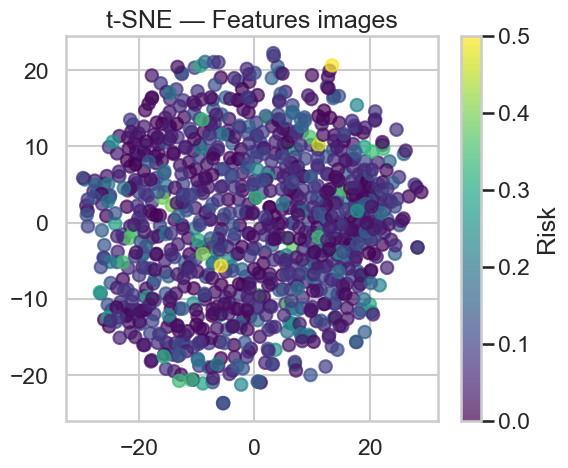


=== FUSION TAB + IMG ===
X_train_tab : (1000, 11)
X_train_img : (1000, 64)
X_train_comb: (1000, 75)
X_test_comb : (500, 75)

 TABULAR + IMAGE merge complete.
  X_train_combined : (1000, 75)
  X_test_combined  : (500, 75)

 Retraining the best model from Part 2...

XGBoost performance on combined data :
   RMSE train : 0.02041
   RMSE test  : 0.04051
   R² train   : 0.9362
   R² test    : 0.7565

===  Part 2 vs Part 3 comparison===
                       Version  RMSE_test   R2_test
0         Tabulaire (Partie 2)   0.041367  0.746129
1  Tabulaire+Images (Partie 3)   0.040513  0.756503 



C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\1401901124.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison, x="Version", y="RMSE_test", palette="mako")


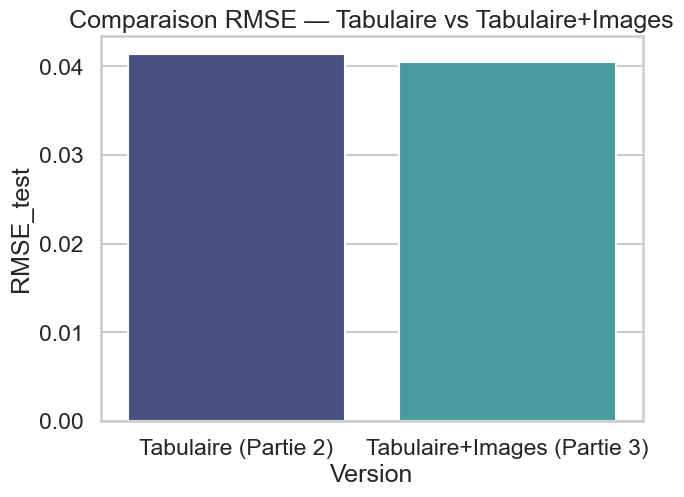

C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\1401901124.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison, x="Version", y="R2_test", palette="crest")


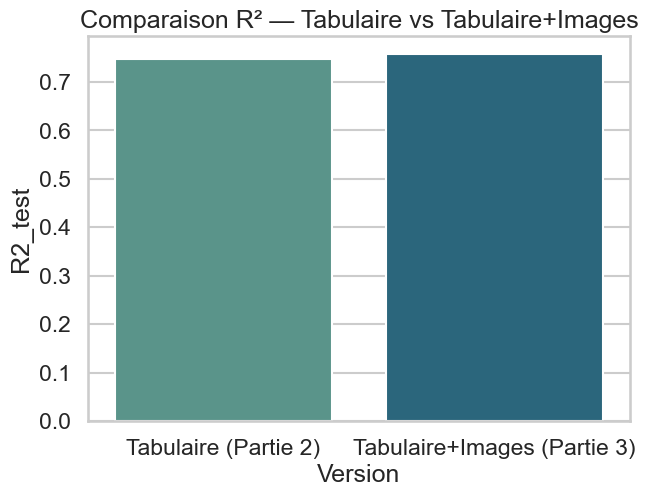

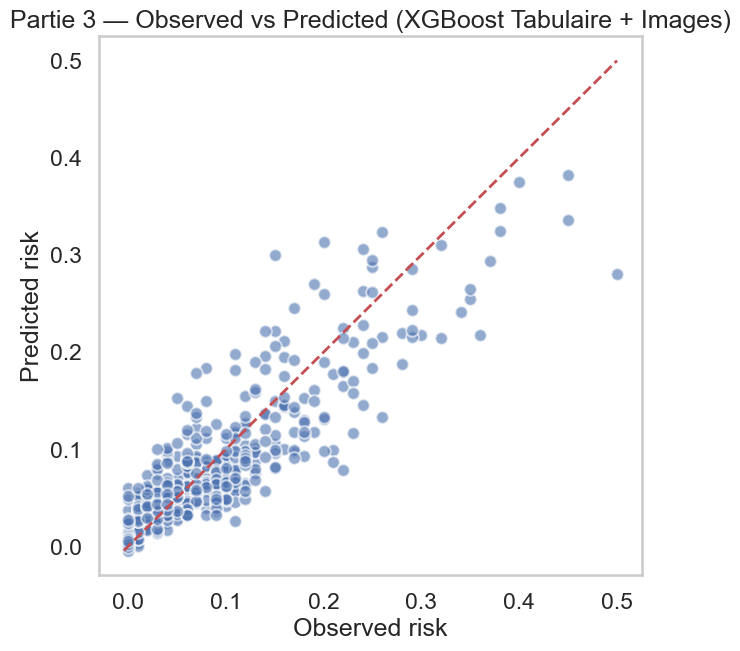


=== Top Feature Importance -XGBoost Tabulaire + Image ===


,Feature,Importance
0,blood pressure,0.196292
3,cholesterol,0.062564
2,weight,0.048446
5,hemoglobin,0.041792
43,img_feat_32,0.027752
1,potassium,0.027427
9,height,0.024372
4,age,0.023865
64,img_feat_53,0.023122
67,img_feat_56,0.021344


C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\1401901124.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=p.head(20), x="Importance", y="Feature", palette ="viridis")


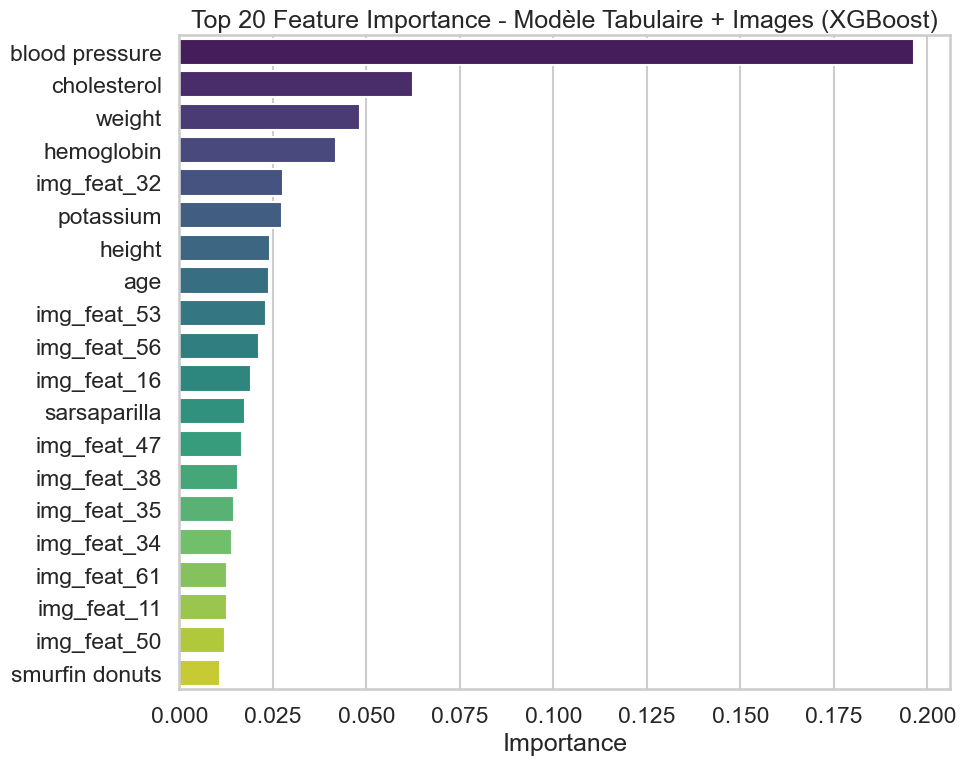


 PART 3 COMPLETED.



In [69]:
# ================================================================
# PARTIE 3 :  Integration of Image Data
# ================================================================
#torch.manual_seed(42)
#np.random.seed(42)
# ---- Import utils ----
from p3_utils import (
    HeartImageDataset,
    build_image_dataloader,
    SimpleCNNExtractor,
    extract_image_features,
    combine_tabular_and_image_features,
    show_image_grid,      
    tsne_plot             
)

sns.set_style("whitegrid")


# ================================================================
# 0. Check that the necessary items from parts 1 and 2 are present
# ================================================================
required = ["X_train_corr", "X_test_corr", "selected_features_nl", "y_train", "y_test", "best_estimator"]
missing = [name for name in required if name not in globals()]

if missing:
    raise RuntimeError(f"Missing items from parts 1 and 2 : {missing}")

print(" Loading all objects from part 2 \n")


#----------------------Conversions of y_train and y_test to 1D------------------------------------------------------
y_train_vec = np.ravel(y_train.values if isinstance(y_train, pd.DataFrame) else y_train)
y_test_vec  = np.ravel(y_test.values  if isinstance(y_test, pd.DataFrame)  else y_test)


# ================================================================
# 1. Preparation of all tabular variables selected in  part 2  
# ================================================================
train_cols = list(X_train_corr.columns)
resolved = []

# resolve any spacing issues in names
for f in selected_features_nl:
    if f in train_cols:
        resolved.append(f)
    elif f.replace(" ", "_") in train_cols:
        resolved.append(f.replace(" ", "_"))
    elif f.replace("_", " ") in train_cols:
        resolved.append(f.replace("_", " "))
    else:
        print(f" Variable ignored (not found) : {f}")

selected_features_nl = resolved

X_train_nonlin = X_train_corr[selected_features_nl].copy()
X_test_nonlin  = X_test_corr[selected_features_nl].copy()

print(" Tabular data for Part 2 ready  :")
print(f"   -> {len(selected_features_nl)} selected variables.\n")


# ================================================================
# 2. Load image file names
# ================================================================
data_root = r"C:\Users\edoun\Documents\Master 2\master_2026\LELEC2870\True_project\data\data\data_labeled"

df_Xtrain_raw = pd.read_csv(os.path.join(data_root, "X_train.csv"))
df_Xtest_raw  = pd.read_csv(os.path.join(data_root, "X_test.csv"))

img_train_filenames = df_Xtrain_raw["img_filename"].tolist()
img_test_filenames  = df_Xtest_raw["img_filename"].tolist()

train_img_dir = os.path.join(data_root, "Img_train")
test_img_dir  = os.path.join(data_root, "Img_test")

print(" Image files detected :")
print(len(img_train_filenames), "images train")
print(len(img_test_filenames),  "images test\n")

# ================================================================
# 3. Construct Dataset + DataLoader
# ================================================================
dataset_train_img = HeartImageDataset(img_train_filenames, train_img_dir)
dataset_test_img  = HeartImageDataset(img_test_filenames, test_img_dir)

loader_train_img = build_image_dataloader(dataset_train_img, batch_size=32, shuffle= False)
loader_test_img  = build_image_dataloader(dataset_test_img, batch_size=32, shuffle=False)

print(" DataLoaders created.\n")

#----------------------------Sample display-------------------------------------------------
show_image_grid(img_train_filenames, train_img_dir, n=12)  

# ================================================================
# 4.Feature extraction via simple CNN
# ================================================================
print("Feature extraction via simple CNN...\n")

cnn = SimpleCNNExtractor()
X_train_img = extract_image_features(cnn, loader_train_img)
X_test_img  = extract_image_features(cnn, loader_test_img)

print(" Extraction complete.")
print(f"  X_train_img : {X_train_img.shape}")
print(f"  X_test_img  : {X_test_img.shape}\n")

#---------------------------t-SNE (image display)-----------------------------------------------------------
tsne_plot(X_train_img, y_train_vec, title="t-SNE — Features images")


# ================================================================
# 5. TABULAR + IMAGE merge (fusion)
# ================================================================
X_train_combined, X_test_combined, feature_names = combine_tabular_and_image_features(
    X_train_nonlin, X_test_nonlin,
    X_train_img, X_test_img
)


print("\n TABULAR + IMAGE merge complete.")
print(f"  X_train_combined : {X_train_combined.shape}")
print(f"  X_test_combined  : {X_test_combined.shape}\n")


# ================================================================
# 6. Final model = XGBoost (same hyperparameters as Part 2)
# ================================================================
print(" Retraining the best model from Part 2...\n")

best_params = best_estimator.get_params()

# -----------------prevent duplicate parameters------------------------------
for key in ["objective", "tree_method"]:
    if key in best_params:
        best_params.pop(key)

model_tab_image = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    tree_method="hist"
)

model_tab_image.fit(X_train_combined, y_train_vec)


#--------------------predictions-------------------------------------------------
y_pred_train = model_tab_image.predict(X_train_combined)
y_pred_test  = model_tab_image.predict(X_test_combined)

rmse_train = np.sqrt(mean_squared_error(y_train_vec, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_vec,  y_pred_test))

r2_train = r2_score(y_train_vec, y_pred_train)
r2_test  = r2_score(y_test_vec,  y_pred_test)

print("XGBoost performance on combined data :")
print(f"   RMSE train : {rmse_train:.5f}")
print(f"   RMSE test  : {rmse_test:.5f}")
print(f"   R² train   : {r2_train:.4f}")
print(f"   R² test    : {r2_test:.4f}\n")


# ================================================================
# 7.  Part 2 vs Part 3 comparison
# ================================================================
rmse_tab_p2 = best_estimator.score(X_test_nonlin, y_test_vec)

comparison = pd.DataFrame({
    "Version": ["Tabulaire (Partie 2)", "Tabulaire+Images (Partie 3)"],
    "RMSE_test": [np.sqrt(mean_squared_error(y_test_vec, best_estimator.predict(X_test_nonlin))),
                  rmse_test],
    "R2_test": [r2_score(y_test_vec, best_estimator.predict(X_test_nonlin)),
                r2_test]
})

print("===  Part 2 vs Part 3 comparison===")
print(comparison, "\n")


# ================================================================
# 8.Finales figures
# ================================================================
plt.figure(figsize=(7,5))
sns.barplot(data=comparison, x="Version", y="RMSE_test", palette="mako")
plt.title("Comparaison RMSE — Tabulaire vs Tabulaire+Images")
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(data=comparison, x="Version", y="R2_test", palette="crest")
plt.title("Comparaison R² — Tabulaire vs Tabulaire+Images")
plt.show()

plt.figure(figsize=(7,7))
plt.scatter(y_test_vec, y_pred_test, alpha=0.6, edgecolors="white")
m, M = min(y_test_vec.min(), y_pred_test.min()), max(y_test_vec.max(), y_pred_test.max())
plt.plot([m, M], [m, M], "r--", lw=2)
plt.xlabel("Observed risk")
plt.ylabel("Predicted risk")
plt.title("Partie 3 — Observed vs Predicted (XGBoost Tabulaire + Images)")
plt.grid()
plt.show()


#==========================================================================================
# 9. Feature importance: modèle tabulaire + images
#==========================================================================================

# --------------- Noms des features: tabulaire + image-----------------------
tab_features = list(selected_features_nl)
img_features = [f"img_feat_{i}" for i in range (X_train_img.shape[1])]
names_feature = tab_features +img_features


importances = model_tab_image.feature_importances_

p=pd.DataFrame({
    "Feature": names_feature,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\n=== Top Feature Importance -XGBoost Tabulaire + Image ===")
display(p.head(20))

#------------------------------plot-----------------------------------

plt.figure(figsize=(10,8))
sns.barplot(data=p.head(20), x="Importance", y="Feature", palette ="viridis")
plt.title("Top 20 Feature Importance - Modèle Tabulaire + Images (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()
#========================================================================
print("\n PART 3 COMPLETED.\n")
#======================================================================

---

# Part 4 : Understanding Heart Failure in Smurf Society

In this final section, the objective is no longer to improve the performance of predictive models. The focus is now on examining the mechanisms that could explain the risk of heart failure within the Smurf population. Drawing on all the results obtained in the previous sections, in particular the tabular models, the multimodal model incorporating images, the analysis of variable importance and the various visualisations, we seek to identify the factors that have the most significant influence on cardiac risk. This analysis also aims to determine which groups appear to be most vulnerable and to formulate plausible hypotheses regarding the potential causes of this risk. The approach adopted is both synthetic and explanatory, based on graphical representations to support interpretation.

---

### 4.2 Identification of the groups most at risk 



In [70]:
# ------------Final model variables-----------------------------
y_pred = y_pred_test  
X = X_test_corr.copy()
X["pred_risk"] = y_pred

# ------------1.high Blood Pressure = top 20%----------------
bp_col = "blood pressure"
bp_threshold = X[bp_col].quantile(0.80)
group_bp = X[X[bp_col] >= bp_threshold]["pred_risk"].mean()

# -----------2.High cholesterol = top 20%---------------------
chol_col = "cholesterol"
chol_threshold = X[chol_col].quantile(0.80)
group_chol = X[X[chol_col] >= chol_threshold]["pred_risk"].mean()

# --------3. High Blood Pressure + High cholesterol-----------
group_bp_chol = X[
    (X[bp_col] >= bp_threshold) &
    (X[chol_col] >= chol_threshold)
]["pred_risk"].mean()

# -----4. Profession : Resource Extraction--------------------
prof_col = "profession_resource extraction"
group_prof = X[X[prof_col] == 1]["pred_risk"].mean()

# ------------Final summary---------------------------------
results = pd.DataFrame({
    "Group": [
        "Very high blood pressure",
        "High cholesterol",
        "High Blood Pressure + High Cholesterol",
        "Profession : Resource Extraction"
    ],
    "Average risk": [
        group_bp,
        group_chol,
        group_bp_chol,
        group_prof
    ]
})

results


,Group,Average risk
0,Very high blood pressure,0.183183
1,High cholesterol,0.150726
2,High Blood Pressure + High Cholesterol,0.201718
3,Profession : Resource Extraction,0.061716


In [71]:
print (list(X_test_corr.columns))

['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight', 'profession_administration and governance', 'profession_craftsmanship', 'profession_food production', 'profession_manufacturing', 'profession_resource extraction', 'profession_services']


C:\Users\edoun\AppData\Local\Temp\ipykernel_26836\3602282591.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="BP_quartile", y="predicted_risk", palette="Blues")


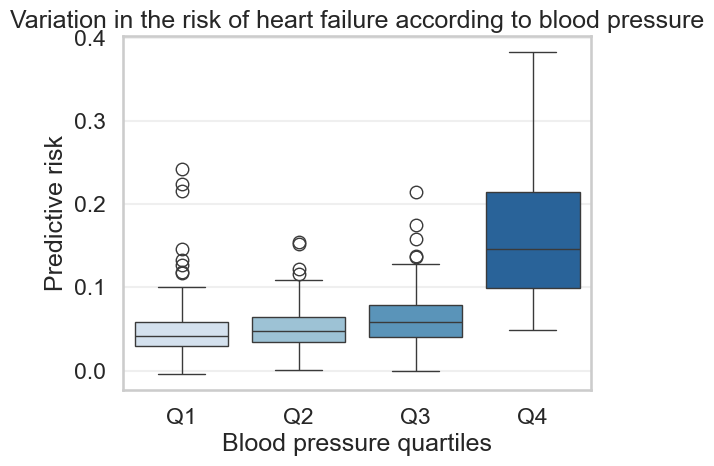

In [72]:
# --- Physiological variable to be analysed ---
var = "blood pressure"  

# --- Retrieving test values for this variable ---
bp = X_test_corr[var].values
pred = y_pred_test

# --- Building a dataframe for the plot ---
df_plot = pd.DataFrame({
    var: bp,
    "predicted_risk": pred
})

# --- Creation of quartiles ---
df_plot["BP_quartile"] = pd.qcut(df_plot[var], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# --- Graphe ---
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_plot, x="BP_quartile", y="predicted_risk", palette="Blues")

plt.xlabel("Blood pressure quartiles")
plt.ylabel("Predictive risk")
plt.title("Variation in the risk of heart failure according to blood pressure")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


---

#### 4.3 Interactions between factors: joint analysis

Columns used to train the model :
[np.str_('blood pressure'), np.str_('potassium'), np.str_('weight'), np.str_('cholesterol'), np.str_('age'), np.str_('hemoglobin'), np.str_('sarsaparilla'), np.str_('smurfin donuts'), np.str_('vitamin D'), np.str_('height'), np.str_('profession_resource extraction')]
→ BP column  : blood pressure
→ Chol column: cholesterol


<Figure size 800x600 with 0 Axes>

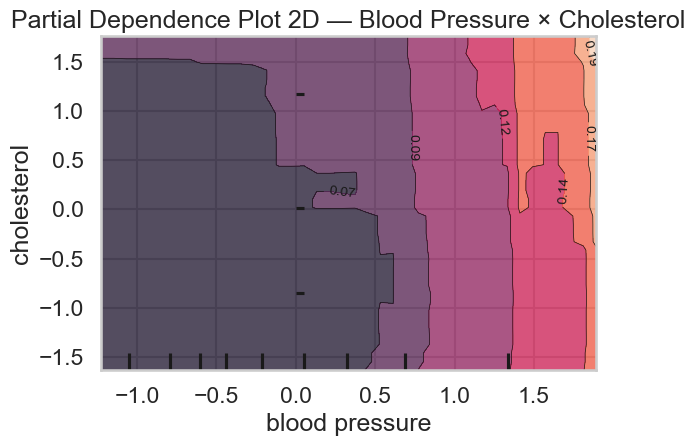

In [73]:
from sklearn.inspection import PartialDependenceDisplay
# ------------------------------------------------------------
# 0. Check that best_estimator (XGBoost) is loaded correctly.
# ------------------------------------------------------------
model = best_estimator  
if hasattr(model, "feature_names_in_"):
    model_cols = list(model.feature_names_in_)
else:
    model_cols = model.get_booster().feature_names
print("Columns used to train the model :")
print(model_cols)
X_pdp =X_train_corr[model_cols].copy()

# ------------------------------------------------------------
# 1. Identify the columns correctly
# ------------------------------------------------------------
def find_column(name, columns):
    candidates = {name,
                  name.replace(" ", "_"),
                  name.replace("_", " "),
                  name.lower()}
    for col in columns:
        if col in candidates or col.lower() in candidates:
            return col
    raise ValueError(f"Colonne introuvable : {name}")

bp_col   = find_column("blood pressure",  X_pdp.columns)
chol_col = find_column("cholesterol",     X_pdp.columns)

print("→ BP column  :", bp_col)
print("→ Chol column:", chol_col)

# ------------------------------------------------------------
# 2) PDP 2D 
# ------------------------------------------------------------
features_2d = [[
    X_pdp.columns.get_loc(bp_col),
    X_pdp.columns.get_loc(chol_col)
]]

fig = plt.figure(figsize=(8, 6))
display = PartialDependenceDisplay.from_estimator(
    model,
    X_pdp,
    features=features_2d,
    kind="average",
    grid_resolution=40
)

plt.title("Partial Dependence Plot 2D — Blood Pressure × Cholesterol")
plt.tight_layout()
plt.show()


----

### Partie Finale: Prédictions sur les données non labellisées

In [74]:
#===========================================================
# Final Part: Predictions on unlabelled data
#============================================================

from p3_utils import (
    HeartImageDataset,
    build_image_dataloader,
    SimpleCNNExtractor,
    extract_image_features,
    combine_tabular_and_image_features             
)

print("\n=== Prédictions sur les données non labellisées ===\n")

#----1. charger le fichier X_unlabeled.csv-----------------------

df_unlabeled_raw = pd.read_csv (r"C:\Users\edoun\Documents\Master 2\master_2026\LELEC2870\True_project\data\data\data_unlabeled\X.csv")

#-----2Load the pre-processed tabular features. X_unlab_corr corresponds to the clean dataset (part 1).

X_unlab_tab = X_unlab_corr[selected_features_nl].copy()

#-----3. load the list of images------------------------------------

img_files_unlab = df_unlabeled_raw["img_filename"].tolist()

#-------------------------4. Folder of unlabelled images (path)------------------------------

img_dir_unlab = r"C:\Users\edoun\Documents\Master 2\master_2026\LELEC2870\True_project\data\data\data_unlabeled\Img"

#-------------5. build the dataset and dataloader ------------------------

dataset_unlab_img = HeartImageDataset(img_files_unlab, img_dir_unlab)
loader_unlab_img = build_image_dataloader(dataset_unlab_img, batch_size=32)

#-------------6. Extract image features ---------------------------------
cnn=SimpleCNNExtractor()
X_unlab_img = extract_image_features(cnn, loader_unlab_img)
print("Features image extraires :", X_unlab_img.shape)

#------------7. Merge tables + images

X_unlab_combined ,_,_= combine_tabular_and_image_features(
    X_unlab_tab,  X_unlab_tab,
     X_unlab_img,  X_unlab_img,
    img_feature_prefix="img_feat"
)

X_unlab_combined  = X_unlab_combined [:,:]           # keep only first output

print("Fusion tabulaire+image effectuée :", X_unlab_combined.shape)
#np.hstack([X_unlab_corr.values, X_unlab_img])

#------------------8. predict the risk --------------------------------------------

y_pred_unlab = model_tab_image.predict(X_unlab_combined)
print("Prediction effectuées :", y_pred_unlab.shape)

df_pred = pd.DataFrame({"predicted_risk": y_pred_unlab})
df_pred.to_csv("y_pred.csv", index=False)

print("\n===============================================")
print("End prediction and save to scv ")
print("===============================================")



=== Prédictions sur les données non labellisées ===

Features image extraires : (500, 64)

=== FUSION TAB + IMG ===
X_train_tab : (500, 11)
X_train_img : (500, 64)
X_train_comb: (500, 75)
X_test_comb : (500, 75)
Fusion tabulaire+image effectuée : (500, 75)
Prediction effectuées : (500,)

End prediction and save to scv 
